In [62]:
%load_ext autoreload
%autoreload 2

from lib/fd_imputer import fd_imputer
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt

SyntaxError: invalid syntax (<ipython-input-62-713477b78333>, line 4)

## Set up all paths and labels needed in this notebook

In [20]:
DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/adult.csv'
SPLITS_PATH = 'MLFD_fd_detection/data/'
METANOME_DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/'
FD_PATH = 'MLFD_fd_detection/results/HyFD-1.2-SNAPSHOT.jar2019-05-07T082200_fds'
DATA_TITLE = 'adult'

In [21]:
df_train = pd.read_csv(SPLITS_PATH+'test/'+DATA_TITLE+'_test.csv', header=None)
df_test = pd.read_csv(SPLITS_PATH+'train/'+DATA_TITLE+'_train.csv', header=None)
fds = fd_imputer.read_fds(FD_PATH)
impute_column = str(9)
df_test = df_test.replace('noValueSetHere123156456', np.nan)
df_train = df_train.replace('noValueSetHere123156456', np.nan)

from sklearn import metrics
continuous = [0, 1, 3, 11, 12, 13] # cols containing continuous numbers

## FD_Imputer

### Getting metrics for all FDs in adult.csv

In [18]:
fd_imputer_results

{3: [{'nans': 26048, 'lhs': [0], 'mse': ''}],
 11: [{'nans': 26048, 'lhs': [0], 'mse': ''}],
 13: [{'nans': 26048, 'lhs': [0], 'mse': ''}],
 12: [{'nans': 26048, 'lhs': [0], 'mse': ''},
  {'nans': 26030, 'lhs': [13, 1, 2, 3, 4, 7], 'mse': 0.0},
  {'nans': 26031, 'lhs': [13, 1, 3, 4, 6, 7], 'mse': 229913.4705882353},
  {'nans': 26034, 'lhs': [13, 1, 3, 4, 7, 8], 'mse': 279180.64285714284},
  {'nans': 26030, 'lhs': [13, 1, 2, 3, 5, 7], 'mse': 0.0},
  {'nans': 26031, 'lhs': [13, 1, 3, 5, 6, 7], 'mse': 229913.4705882353},
  {'nans': 26034, 'lhs': [13, 1, 3, 5, 7, 8], 'mse': 279180.64285714284}],
 1: [{'nans': 26048, 'lhs': [0], 'mse': ''}],
 14: [{'lhs': [0],
   'precision': 0.0003051223544399604,
   'recall': 0.017467751842751844,
   'f1': 0.0005997681083992067}],
 4: [{'lhs': [0], 'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
  {'lhs': [5], 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}],
 5: [{'lhs': [0], 'precision': 0, 'recall': 0, 'f1': 0},
  {'lhs': [4], 'precision': 1.0, 'recall': 1.0,

In [22]:
fd_imputer_results = {}
for rhs in fds:
    results = []
    for lhs in fds[rhs]:
        print(rhs, lhs)
        fd = {rhs: lhs}
        df_fd_imputed = fd_imputer.fd_imputer(df_test, df_train, fd)
        
        # make sure that value for missing data is of same type as row to be imputed
        # to avoid mix of labels with scikit.metrics
        if isinstance(df_fd_imputed.loc[0, rhs], str):
            df_fd_imputed = df_fd_imputed.fillna('no value')
            y_pred = df_fd_imputed.loc[:, str(rhs)+'_imputed']
            y_true = df_fd_imputed.loc[:, rhs]
        else:
            # count, when no imputations have been found
            na_selector = df_fd_imputed.loc[:, str(rhs)+'_imputed'].isna()
            nans = na_selector.sum()
            
            # only retrieve successfully imputed values to compute MSE
            y_pred = df_fd_imputed.loc[~na_selector, str(rhs)+'_imputed']
            y_true = df_fd_imputed.loc[~na_selector, rhs]

        
        if rhs in continuous:
            mse = ''
            
            if  len(y_pred) > 0:
                mse = metrics.mean_squared_error(y_true, y_pred)
            
            result = {
                'nans': nans,
                'lhs': lhs,
                'mse': mse
            }
        else:
            result = {
                'lhs': lhs,
                'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
                'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
                'f1': metrics.f1_score(y_true, y_pred, average='weighted')
            }
        results.append(result)
    fd_imputer_results[rhs] = results

3 [0]
11 [0]
13 [0]
12 [0]
12 [13, 1, 2, 3, 4, 7]
12 [13, 1, 3, 4, 6, 7]
12 [13, 1, 3, 4, 7, 8]
12 [13, 1, 2, 3, 5, 7]
12 [13, 1, 3, 5, 6, 7]
12 [13, 1, 3, 5, 7, 8]
1 [0]
14 [0]


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4 [0]


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


4 [5]
5 [0]
5 [4]
7 [0]
2 [0]
6 [0]
6 [11, 13, 1, 3, 7, 8]
6 [13, 1, 3, 4, 7, 8]
6 [13, 1, 3, 5, 7, 8]
8 [0]
9 [0]
9 [11, 12, 13, 3, 7, 8]
9 [12, 13, 15, 3, 4, 6, 8]
9 [12, 13, 15, 3, 5, 6, 8]
9 [13, 1, 3, 4]
9 [13, 1, 3, 5]
9 [13, 1, 2, 3, 7]
9 [13, 14, 3, 4, 7]
9 [13, 14, 3, 4, 6, 8]
9 [13, 14, 3, 5, 7]
9 [13, 14, 3, 5, 6, 8]
9 [13, 14, 2, 3, 7]
9 [13, 14, 3, 6, 7]
9 [13, 14, 3, 7, 8]
9 [10, 13, 14, 15, 3, 7]
9 [13, 15, 2, 3, 4, 6, 8]
9 [13, 15, 2, 3, 5, 6, 8]
9 [12, 14, 2, 3, 4, 6, 8]
9 [12, 14, 2, 3, 5, 6, 8]
9 [12, 15, 2, 3, 4, 6, 8]
9 [12, 15, 2, 3, 5, 6, 8]
9 [14, 1, 3, 4]
9 [14, 1, 3, 5]
9 [14, 1, 2, 3, 7]
9 [14, 1, 2, 3, 6]
9 [1, 3, 4, 6]
9 [1, 3, 4, 8]
9 [15, 1, 3, 4]
9 [1, 3, 5, 6]
9 [1, 3, 5, 8]
9 [15, 1, 3, 5]
9 [1, 3, 6, 7]
9 [1, 3, 7, 8]
9 [15, 1, 3, 7]
9 [10, 14, 3, 4, 7]
9 [14, 15, 2, 3, 4, 6, 8]
9 [10, 14, 3, 5, 7]
9 [14, 15, 2, 3, 5, 6, 8]
9 [3, 4, 7, 8]
9 [3, 5, 7, 8]
10 [0]
10 [11, 12, 13, 2, 3, 4, 8]
10 [11, 12, 13, 2, 3, 5, 8]
10 [9, 11, 13, 2, 3, 4, 8]
10 [11, 1

In [80]:
precision = [e['precision'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
recall = [e['recall'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
f1 = [e['f1'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
rhs_color = [rhs for rhs in fd_imputer_results 
           for e in fd_imputer_results[rhs]]

area = [x*4000 for x in f1]
colormap = plt.cm.get_cmap('RdYlBu')

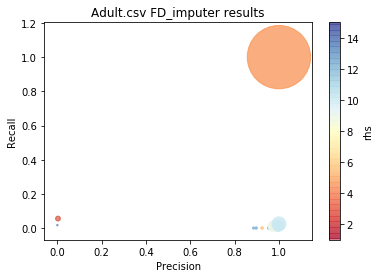

In [86]:
fig, ax = plt.subplots()
sc = plt.scatter(precision, 
                 recall, 
                 cmap=colormap,
                 c=rhs_color, 
                 s=area, 
                 alpha=0.5)
plt.colorbar(sc, label='rhs')
ax.set(title='Adult.csv FD_imputer results',
      xlabel = 'Precision',
      ylabel = 'Recall')
fig.savefig('fd_imputer_performance.png', transparent=False,
           dpi=320, bbox_inches='tight')

## ML imputation on fd's

In [23]:
ml_imputer_results = {}
for rhs in fds:
    results = []
    for lhs in fds[rhs]:
        relevant_cols = lhs + [rhs]
        
        # make sure that datawig doesn't perform regression on categories
        # also, select relevant subsets
        if rhs not in continuous:
            df_subset_train = df_train.iloc[:, relevant_cols].astype(
                {rhs: str})
            df_subset_test = df_test.iloc[:, relevant_cols].astype(
                {rhs: str})
        else:
            df_subset_train = df_train.iloc[:, relevant_cols]
            df_subset_test = df_test.iloc[:, relevant_cols]
        
        print(rhs, lhs)
        df_imputed = fd_imputer.ml_imputer(df_subset_train, 
                                           df_subset_test, 
                                           str(rhs))
        
        y_pred = df_imputed.loc[:, str(rhs)+'_imputed']
        y_true = df_imputed.loc[:, str(rhs)]
                
        if rhs in continuous:
            result = {
                'lhs': lhs,
                'mse': metrics.mean_squared_error(y_true, y_pred)
            }
        else:
            result = {
                'lhs': lhs,
                'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
                'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
                'f1': metrics.f1_score(y_true, y_pred, average='weighted')
            }
        results.append(result)
    ml_imputer_results[rhs] = results

3 [0]


2019-06-13 11:13:57,051 [INFO]  
========== start: fit model
2019-06-13 11:13:57,052 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:13:57,274 [INFO]  Epoch[0] Batch [0-184]	Speed: 13724.87 samples/sec	cross-entropy=0.650560	3-accuracy=0.000000
2019-06-13 11:13:57,477 [INFO]  Epoch[0] Train-cross-entropy=0.328888
2019-06-13 11:13:57,478 [INFO]  Epoch[0] Train-3-accuracy=0.000000
2019-06-13 11:13:57,480 [INFO]  Epoch[0] Time cost=0.424
2019-06-13 11:13:57,485 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:13:57,520 [INFO]  Epoch[0] Validation-cross-entropy=0.001155
2019-06-13 11:13:57,524 [INFO]  Epoch[0] Validation-3-accuracy=0.000000
2019-06-13 11:13:57,752 [INFO]  Epoch[1] Batch [0-184]	Speed: 13170.99 samples/sec	cross-entropy=0.001024	3-accuracy=0.000000
2019-06-13 11:13:57,970 [INFO]  Epoch[1] Train-cross-entropy=0.000805
2019-06-13 11:13:57,971 [INFO]  Epoch[1] Train-3-accuracy=0.000000
2019-06-13 11:13:57,972 [INFO]  Epoch[1] Time cost=0.447


11 [0]


2019-06-13 11:14:01,085 [INFO]  
========== start: fit model
2019-06-13 11:14:01,086 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:14:01,447 [INFO]  Epoch[0] Batch [0-184]	Speed: 8289.50 samples/sec	cross-entropy=0.433321	11-accuracy=0.000000
2019-06-13 11:14:01,666 [INFO]  Epoch[0] Train-cross-entropy=1.004092
2019-06-13 11:14:01,668 [INFO]  Epoch[0] Train-11-accuracy=0.000000
2019-06-13 11:14:01,673 [INFO]  Epoch[0] Time cost=0.585
2019-06-13 11:14:01,681 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:14:01,731 [INFO]  Epoch[0] Validation-cross-entropy=4.391209
2019-06-13 11:14:01,736 [INFO]  Epoch[0] Validation-11-accuracy=0.000000
2019-06-13 11:14:01,981 [INFO]  Epoch[1] Batch [0-184]	Speed: 12268.12 samples/sec	cross-entropy=0.753272	11-accuracy=0.000000
2019-06-13 11:14:02,191 [INFO]  Epoch[1] Train-cross-entropy=0.386354
2019-06-13 11:14:02,192 [INFO]  Epoch[1] Train-11-accuracy=0.000000
2019-06-13 11:14:02,194 [INFO]  Epoch[1] Time cost=0.

13 [0]


2019-06-13 11:14:05,388 [INFO]  
========== start: fit model
2019-06-13 11:14:05,395 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:14:05,685 [INFO]  Epoch[0] Batch [0-184]	Speed: 10377.44 samples/sec	cross-entropy=0.343279	13-accuracy=0.000000
2019-06-13 11:14:05,942 [INFO]  Epoch[0] Train-cross-entropy=0.173744
2019-06-13 11:14:05,945 [INFO]  Epoch[0] Train-13-accuracy=0.000000
2019-06-13 11:14:05,946 [INFO]  Epoch[0] Time cost=0.547
2019-06-13 11:14:05,951 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:14:05,978 [INFO]  Epoch[0] Validation-cross-entropy=0.002151
2019-06-13 11:14:05,979 [INFO]  Epoch[0] Validation-13-accuracy=0.000000
2019-06-13 11:14:06,197 [INFO]  Epoch[1] Batch [0-184]	Speed: 13819.26 samples/sec	cross-entropy=0.000549	13-accuracy=0.000000
2019-06-13 11:14:06,405 [INFO]  Epoch[1] Train-cross-entropy=0.000671
2019-06-13 11:14:06,407 [INFO]  Epoch[1] Train-13-accuracy=0.000000
2019-06-13 11:14:06,408 [INFO]  Epoch[1] Time cost=0

12 [0]


2019-06-13 11:14:08,425 [INFO]  
========== start: fit model
2019-06-13 11:14:08,426 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:14:08,624 [INFO]  Epoch[0] Batch [0-184]	Speed: 15490.28 samples/sec	cross-entropy=0.741074	12-accuracy=0.000000
2019-06-13 11:14:08,814 [INFO]  Epoch[0] Train-cross-entropy=0.374999
2019-06-13 11:14:08,815 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:14:08,816 [INFO]  Epoch[0] Time cost=0.385
2019-06-13 11:14:08,819 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:14:08,839 [INFO]  Epoch[0] Validation-cross-entropy=0.001079
2019-06-13 11:14:08,841 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:14:09,040 [INFO]  Epoch[1] Batch [0-184]	Speed: 15105.44 samples/sec	cross-entropy=0.000592	12-accuracy=0.000000
2019-06-13 11:14:09,243 [INFO]  Epoch[1] Train-cross-entropy=0.000520
2019-06-13 11:14:09,244 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:14:09,245 [INFO]  Epoch[1] Time cost=0

12 [13, 1, 2, 3, 4, 7]


2019-06-13 11:14:12,018 [INFO]  
========== start: fit model
2019-06-13 11:14:12,020 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:14:13,701 [INFO]  Epoch[0] Batch [0-184]	Speed: 1764.95 samples/sec	cross-entropy=0.717948	12-accuracy=0.000000
2019-06-13 11:14:15,834 [INFO]  Epoch[0] Train-cross-entropy=0.365676
2019-06-13 11:14:15,838 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:14:15,839 [INFO]  Epoch[0] Time cost=3.816
2019-06-13 11:14:15,843 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:14:16,274 [INFO]  Epoch[0] Validation-cross-entropy=0.003246
2019-06-13 11:14:16,275 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:14:18,281 [INFO]  Epoch[1] Batch [0-184]	Speed: 1476.70 samples/sec	cross-entropy=0.002919	12-accuracy=0.000000
2019-06-13 11:14:20,379 [INFO]  Epoch[1] Train-cross-entropy=0.003656
2019-06-13 11:14:20,382 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:14:20,385 [INFO]  Epoch[1] Time cost=4.1

12 [13, 1, 3, 4, 6, 7]


2019-06-13 11:14:48,458 [INFO]  
========== start: fit model
2019-06-13 11:14:48,460 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:14:50,550 [INFO]  Epoch[0] Batch [0-184]	Speed: 1421.18 samples/sec	cross-entropy=0.686817	12-accuracy=0.000000
2019-06-13 11:14:52,743 [INFO]  Epoch[0] Train-cross-entropy=0.348925
2019-06-13 11:14:52,745 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:14:52,748 [INFO]  Epoch[0] Time cost=4.283
2019-06-13 11:14:52,753 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:14:53,303 [INFO]  Epoch[0] Validation-cross-entropy=0.003968
2019-06-13 11:14:53,304 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:14:55,325 [INFO]  Epoch[1] Batch [0-184]	Speed: 1468.64 samples/sec	cross-entropy=0.004635	12-accuracy=0.000000
2019-06-13 11:14:57,924 [INFO]  Epoch[1] Train-cross-entropy=0.004553
2019-06-13 11:14:57,925 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:14:57,927 [INFO]  Epoch[1] Time cost=4.6

12 [13, 1, 3, 4, 7, 8]


2019-06-13 11:15:27,719 [INFO]  
========== start: fit model
2019-06-13 11:15:27,720 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:15:29,642 [INFO]  Epoch[0] Batch [0-184]	Speed: 1546.81 samples/sec	cross-entropy=0.612177	12-accuracy=0.000000
2019-06-13 11:15:31,868 [INFO]  Epoch[0] Train-cross-entropy=0.311633
2019-06-13 11:15:31,870 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:15:31,871 [INFO]  Epoch[0] Time cost=4.145
2019-06-13 11:15:31,882 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:15:32,279 [INFO]  Epoch[0] Validation-cross-entropy=0.006887
2019-06-13 11:15:32,281 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:15:34,304 [INFO]  Epoch[1] Batch [0-184]	Speed: 1464.35 samples/sec	cross-entropy=0.009843	12-accuracy=0.000000
2019-06-13 11:15:37,556 [INFO]  Epoch[1] Train-cross-entropy=0.007658
2019-06-13 11:15:37,558 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:15:37,559 [INFO]  Epoch[1] Time cost=5.2

12 [13, 1, 2, 3, 5, 7]


2019-06-13 11:16:35,468 [INFO]  
========== start: fit model
2019-06-13 11:16:35,469 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:16:38,434 [INFO]  Epoch[0] Batch [0-184]	Speed: 998.98 samples/sec	cross-entropy=0.722115	12-accuracy=0.000000
2019-06-13 11:16:41,336 [INFO]  Epoch[0] Train-cross-entropy=0.369905
2019-06-13 11:16:41,337 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:16:41,340 [INFO]  Epoch[0] Time cost=5.866
2019-06-13 11:16:41,348 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:16:41,902 [INFO]  Epoch[0] Validation-cross-entropy=0.008485
2019-06-13 11:16:41,903 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:16:44,934 [INFO]  Epoch[1] Batch [0-184]	Speed: 977.53 samples/sec	cross-entropy=0.006523	12-accuracy=0.000000
2019-06-13 11:16:47,768 [INFO]  Epoch[1] Train-cross-entropy=0.006841
2019-06-13 11:16:47,770 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:16:47,774 [INFO]  Epoch[1] Time cost=5.868

12 [13, 1, 3, 5, 6, 7]


2019-06-13 11:17:50,816 [INFO]  
========== start: fit model
2019-06-13 11:17:50,818 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:17:52,725 [INFO]  Epoch[0] Batch [0-184]	Speed: 1561.43 samples/sec	cross-entropy=0.804172	12-accuracy=0.000000
2019-06-13 11:17:55,550 [INFO]  Epoch[0] Train-cross-entropy=0.410363
2019-06-13 11:17:55,554 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:17:55,555 [INFO]  Epoch[0] Time cost=4.734
2019-06-13 11:17:55,563 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:17:55,964 [INFO]  Epoch[0] Validation-cross-entropy=0.009540
2019-06-13 11:17:55,967 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:17:58,401 [INFO]  Epoch[1] Batch [0-184]	Speed: 1216.42 samples/sec	cross-entropy=0.008171	12-accuracy=0.000000
2019-06-13 11:18:00,613 [INFO]  Epoch[1] Train-cross-entropy=0.007713
2019-06-13 11:18:00,616 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:18:00,618 [INFO]  Epoch[1] Time cost=4.6

12 [13, 1, 3, 5, 7, 8]


2019-06-13 11:18:38,550 [INFO]  
========== start: fit model
2019-06-13 11:18:38,552 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:18:41,026 [INFO]  Epoch[0] Batch [0-184]	Speed: 1198.41 samples/sec	cross-entropy=0.897732	12-accuracy=0.000000
2019-06-13 11:18:43,448 [INFO]  Epoch[0] Train-cross-entropy=0.462504
2019-06-13 11:18:43,450 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-13 11:18:43,452 [INFO]  Epoch[0] Time cost=4.897
2019-06-13 11:18:43,458 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:18:43,878 [INFO]  Epoch[0] Validation-cross-entropy=0.015201
2019-06-13 11:18:43,882 [INFO]  Epoch[0] Validation-12-accuracy=0.000000
2019-06-13 11:18:46,351 [INFO]  Epoch[1] Batch [0-184]	Speed: 1201.64 samples/sec	cross-entropy=0.012151	12-accuracy=0.000000
2019-06-13 11:18:48,908 [INFO]  Epoch[1] Train-cross-entropy=0.014521
2019-06-13 11:18:48,912 [INFO]  Epoch[1] Train-12-accuracy=0.000000
2019-06-13 11:18:48,918 [INFO]  Epoch[1] Time cost=5.0

1 [0]


2019-06-13 11:19:23,006 [INFO]  
========== start: fit model
2019-06-13 11:19:23,008 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:19:23,303 [INFO]  Epoch[0] Batch [0-184]	Speed: 10350.21 samples/sec	cross-entropy=1.021642	1-accuracy=0.000000
2019-06-13 11:19:23,620 [INFO]  Epoch[0] Train-cross-entropy=0.519072
2019-06-13 11:19:23,623 [INFO]  Epoch[0] Train-1-accuracy=0.000000
2019-06-13 11:19:23,628 [INFO]  Epoch[0] Time cost=0.616
2019-06-13 11:19:23,635 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:19:23,676 [INFO]  Epoch[0] Validation-cross-entropy=0.003881
2019-06-13 11:19:23,679 [INFO]  Epoch[0] Validation-1-accuracy=0.000000
2019-06-13 11:19:24,006 [INFO]  Epoch[1] Batch [0-184]	Speed: 9350.52 samples/sec	cross-entropy=0.001821	1-accuracy=0.000000
2019-06-13 11:19:24,300 [INFO]  Epoch[1] Train-cross-entropy=0.001300
2019-06-13 11:19:24,302 [INFO]  Epoch[1] Train-1-accuracy=0.000000
2019-06-13 11:19:24,303 [INFO]  Epoch[1] Time cost=0.615
2

2019-06-13 11:19:28,671 [INFO]  CategoricalEncoder for column 14                                found only 4 occurrences of value Cambodia
2019-06-13 11:19:28,673 [INFO]  CategoricalEncoder for column 14                                found only 4 occurrences of value Thailand
2019-06-13 11:19:28,674 [INFO]  CategoricalEncoder for column 14                                found only 4 occurrences of value Ireland
2019-06-13 11:19:28,676 [INFO]  CategoricalEncoder for column 14                                found only 3 occurrences of value Yugoslavia
2019-06-13 11:19:28,684 [INFO]  CategoricalEncoder for column 14                                found only 2 occurrences of value Greece
2019-06-13 11:19:28,686 [INFO]  CategoricalEncoder for column 14                                found only 1 occurrences of value Honduras


14 [0]


2019-06-13 11:19:28,983 [WARNING]  Test set does not contain any ocurrences of values [Cambodia, Yugoslavia, Haiti, England, China, Scotland, Poland, Honduras, Portugal, Ecuador, France, Hong, Peru, Trinadad&Tobago, Laos] in column [14], consider using a more representative test set.
2019-06-13 11:19:28,992 [INFO]  
========== start: fit model
2019-06-13 11:19:28,996 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:19:34,600 [INFO]  Epoch[0] Batch [0-184]	Speed: 530.97 samples/sec	cross-entropy=0.657991	14-accuracy=0.903041
2019-06-13 11:19:40,079 [INFO]  Epoch[0] Train-cross-entropy=0.451860
2019-06-13 11:19:40,083 [INFO]  Epoch[0] Train-14-accuracy=0.925068
2019-06-13 11:19:40,085 [INFO]  Epoch[0] Time cost=11.080
2019-06-13 11:19:40,110 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:19:40,672 [INFO]  Epoch[0] Validation-cross-entropy=0.147060
2019-06-13 11:19:40,675 [INFO]  Epoch[0] Validation-14-accuracy=0.963415
2019-06-13 11:19:46,116 [INFO]  E

4 [0]


2019-06-13 11:21:49,608 [INFO]  
========== start: fit model
2019-06-13 11:21:49,610 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:21:52,282 [INFO]  Epoch[0] Batch [0-184]	Speed: 1111.77 samples/sec	cross-entropy=0.867713	4-accuracy=0.842568
2019-06-13 11:21:54,886 [INFO]  Epoch[0] Train-cross-entropy=0.534495
2019-06-13 11:21:54,888 [INFO]  Epoch[0] Train-4-accuracy=0.915872
2019-06-13 11:21:54,889 [INFO]  Epoch[0] Time cost=5.276
2019-06-13 11:21:54,898 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:21:55,247 [INFO]  Epoch[0] Validation-cross-entropy=0.117373
2019-06-13 11:21:55,248 [INFO]  Epoch[0] Validation-4-accuracy=0.996951
2019-06-13 11:21:57,903 [INFO]  Epoch[1] Batch [0-184]	Speed: 1116.29 samples/sec	cross-entropy=0.076884	4-accuracy=0.998311
2019-06-13 11:22:00,517 [INFO]  Epoch[1] Train-cross-entropy=0.059783
2019-06-13 11:22:00,519 [INFO]  Epoch[1] Train-4-accuracy=0.998808
2019-06-13 11:22:00,521 [INFO]  Epoch[1] Time cost=5.271
20

4 [5]


2019-06-13 11:23:25,966 [INFO]  CategoricalEncoder for column 4                                found only 76 occurrences of value Doctorate
2019-06-13 11:23:25,970 [INFO]  CategoricalEncoder for column 4                                found only 52 occurrences of value 5th-6th
2019-06-13 11:23:25,973 [INFO]  CategoricalEncoder for column 4                                found only 31 occurrences of value 1st-4th
2019-06-13 11:23:25,976 [INFO]  CategoricalEncoder for column 4                                found only 9 occurrences of value Preschool
2019-06-13 11:23:26,198 [INFO]  
========== start: fit model
2019-06-13 11:23:26,199 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:23:30,315 [INFO]  Epoch[0] Batch [0-184]	Speed: 724.08 samples/sec	cross-entropy=0.635923	4-accuracy=0.894595
2019-06-13 11:23:34,340 [INFO]  Epoch[0] Train-cross-entropy=0.368119
2019-06-13 11:23:34,345 [INFO]  Epoch[0] Train-4-accuracy=0.944993
2019-06-13 11:23:34,349 [INFO]  Epoch[0] Time cost=8.135


5 [0]


2019-06-13 11:25:20,105 [INFO]  
========== start: fit model
2019-06-13 11:25:20,107 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:25:23,255 [INFO]  Epoch[0] Batch [0-184]	Speed: 944.25 samples/sec	cross-entropy=1.554829	5-accuracy=0.632770
2019-06-13 11:25:27,570 [INFO]  Epoch[0] Train-cross-entropy=1.221578
2019-06-13 11:25:27,573 [INFO]  Epoch[0] Train-5-accuracy=0.711853
2019-06-13 11:25:27,575 [INFO]  Epoch[0] Time cost=7.460
2019-06-13 11:25:27,586 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:25:28,114 [INFO]  Epoch[0] Validation-cross-entropy=0.653221
2019-06-13 11:25:28,115 [INFO]  Epoch[0] Validation-5-accuracy=0.887195
2019-06-13 11:25:33,252 [INFO]  Epoch[1] Batch [0-184]	Speed: 576.48 samples/sec	cross-entropy=0.519644	5-accuracy=0.927365
2019-06-13 11:25:39,778 [INFO]  Epoch[1] Train-cross-entropy=0.435576
2019-06-13 11:25:39,784 [INFO]  Epoch[1] Train-5-accuracy=0.951124
2019-06-13 11:25:39,787 [INFO]  Epoch[1] Time cost=11.671
201

5 [4]


2019-06-13 11:27:08,371 [INFO]  
========== start: fit model
2019-06-13 11:27:08,372 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:27:11,584 [INFO]  Epoch[0] Batch [0-184]	Speed: 924.41 samples/sec	cross-entropy=0.795529	5-accuracy=0.962500
2019-06-13 11:27:15,806 [INFO]  Epoch[0] Train-cross-entropy=0.462082
2019-06-13 11:27:15,810 [INFO]  Epoch[0] Train-5-accuracy=0.980245
2019-06-13 11:27:15,815 [INFO]  Epoch[0] Time cost=7.441
2019-06-13 11:27:15,830 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:27:16,375 [INFO]  Epoch[0] Validation-cross-entropy=0.072099
2019-06-13 11:27:16,379 [INFO]  Epoch[0] Validation-5-accuracy=0.996951
2019-06-13 11:27:20,352 [INFO]  Epoch[1] Batch [0-184]	Speed: 744.15 samples/sec	cross-entropy=0.047163	5-accuracy=0.998311
2019-06-13 11:27:23,781 [INFO]  Epoch[1] Train-cross-entropy=0.036794
2019-06-13 11:27:23,785 [INFO]  Epoch[1] Train-5-accuracy=0.998978
2019-06-13 11:27:23,788 [INFO]  Epoch[1] Time cost=7.407
2019

7 [0]


2019-06-13 11:28:37,902 [INFO]  
========== start: fit model
2019-06-13 11:28:37,903 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:28:40,466 [INFO]  Epoch[0] Batch [0-184]	Speed: 1159.61 samples/sec	cross-entropy=0.882359	7-accuracy=0.893243
2019-06-13 11:28:43,011 [INFO]  Epoch[0] Train-cross-entropy=0.503319
2019-06-13 11:28:43,012 [INFO]  Epoch[0] Train-7-accuracy=0.944823
2019-06-13 11:28:43,015 [INFO]  Epoch[0] Time cost=5.109
2019-06-13 11:28:43,024 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:28:43,380 [INFO]  Epoch[0] Validation-cross-entropy=0.057544
2019-06-13 11:28:43,382 [INFO]  Epoch[0] Validation-7-accuracy=1.000000
2019-06-13 11:28:45,940 [INFO]  Epoch[1] Batch [0-184]	Speed: 1157.83 samples/sec	cross-entropy=0.044079	7-accuracy=0.999662
2019-06-13 11:28:48,467 [INFO]  Epoch[1] Train-cross-entropy=0.034515
2019-06-13 11:28:48,470 [INFO]  Epoch[1] Train-7-accuracy=0.999659
2019-06-13 11:28:48,471 [INFO]  Epoch[1] Time cost=5.088
20

2 [0]


2019-06-13 11:29:48,674 [INFO]  
========== start: fit model
2019-06-13 11:29:48,675 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:29:50,762 [INFO]  Epoch[0] Batch [0-184]	Speed: 1422.41 samples/sec	cross-entropy=0.491937	2-accuracy=0.881757
2019-06-13 11:29:52,788 [INFO]  Epoch[0] Train-cross-entropy=0.287128
2019-06-13 11:29:52,790 [INFO]  Epoch[0] Train-2-accuracy=0.939884
2019-06-13 11:29:52,791 [INFO]  Epoch[0] Time cost=4.114
2019-06-13 11:29:52,797 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:29:53,132 [INFO]  Epoch[0] Validation-cross-entropy=0.044589
2019-06-13 11:29:53,133 [INFO]  Epoch[0] Validation-2-accuracy=1.000000
2019-06-13 11:29:55,130 [INFO]  Epoch[1] Batch [0-184]	Speed: 1484.12 samples/sec	cross-entropy=0.031849	2-accuracy=1.000000
2019-06-13 11:29:57,124 [INFO]  Epoch[1] Train-cross-entropy=0.025063
2019-06-13 11:29:57,126 [INFO]  Epoch[1] Train-2-accuracy=1.000000
2019-06-13 11:29:57,128 [INFO]  Epoch[1] Time cost=3.993
20

6 [0]


2019-06-13 11:30:46,855 [INFO]  
========== start: fit model
2019-06-13 11:30:46,856 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:30:48,942 [INFO]  Epoch[0] Batch [0-184]	Speed: 1423.13 samples/sec	cross-entropy=0.439819	6-accuracy=0.928041
2019-06-13 11:30:50,926 [INFO]  Epoch[0] Train-cross-entropy=0.254929
2019-06-13 11:30:50,928 [INFO]  Epoch[0] Train-6-accuracy=0.962193
2019-06-13 11:30:50,929 [INFO]  Epoch[0] Time cost=4.070
2019-06-13 11:30:50,936 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:30:51,278 [INFO]  Epoch[0] Validation-cross-entropy=0.042574
2019-06-13 11:30:51,279 [INFO]  Epoch[0] Validation-6-accuracy=0.998476
2019-06-13 11:30:53,309 [INFO]  Epoch[1] Batch [0-184]	Speed: 1460.43 samples/sec	cross-entropy=0.025533	6-accuracy=1.000000
2019-06-13 11:30:55,693 [INFO]  Epoch[1] Train-cross-entropy=0.023544
2019-06-13 11:30:55,696 [INFO]  Epoch[1] Train-6-accuracy=0.999319
2019-06-13 11:30:55,697 [INFO]  Epoch[1] Time cost=4.417
20

6 [11, 13, 1, 3, 7, 8]


2019-06-13 11:31:46,943 [INFO]  
========== start: fit model
2019-06-13 11:31:46,945 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:31:49,013 [INFO]  Epoch[0] Batch [0-184]	Speed: 1439.55 samples/sec	cross-entropy=0.483685	6-accuracy=0.880743
2019-06-13 11:31:51,033 [INFO]  Epoch[0] Train-cross-entropy=0.303798
2019-06-13 11:31:51,036 [INFO]  Epoch[0] Train-6-accuracy=0.934435
2019-06-13 11:31:51,039 [INFO]  Epoch[0] Time cost=4.091
2019-06-13 11:31:51,045 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:31:51,355 [INFO]  Epoch[0] Validation-cross-entropy=0.077214
2019-06-13 11:31:51,357 [INFO]  Epoch[0] Validation-6-accuracy=0.993902
2019-06-13 11:31:53,463 [INFO]  Epoch[1] Batch [0-184]	Speed: 1406.11 samples/sec	cross-entropy=0.055217	6-accuracy=0.997635
2019-06-13 11:31:55,474 [INFO]  Epoch[1] Train-cross-entropy=0.046085
2019-06-13 11:31:55,476 [INFO]  Epoch[1] Train-6-accuracy=0.997786
2019-06-13 11:31:55,478 [INFO]  Epoch[1] Time cost=4.120
20

6 [13, 1, 3, 4, 7, 8]


2019-06-13 11:32:47,899 [INFO]  
========== start: fit model
2019-06-13 11:32:47,900 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:32:50,016 [INFO]  Epoch[0] Batch [0-184]	Speed: 1402.43 samples/sec	cross-entropy=0.527405	6-accuracy=0.861486
2019-06-13 11:32:52,070 [INFO]  Epoch[0] Train-cross-entropy=0.339300
2019-06-13 11:32:52,072 [INFO]  Epoch[0] Train-6-accuracy=0.921151
2019-06-13 11:32:52,074 [INFO]  Epoch[0] Time cost=4.170
2019-06-13 11:32:52,080 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:32:52,409 [INFO]  Epoch[0] Validation-cross-entropy=0.096056
2019-06-13 11:32:52,410 [INFO]  Epoch[0] Validation-6-accuracy=0.992378
2019-06-13 11:32:54,436 [INFO]  Epoch[1] Batch [0-184]	Speed: 1465.26 samples/sec	cross-entropy=0.070757	6-accuracy=0.996959
2019-06-13 11:32:56,422 [INFO]  Epoch[1] Train-cross-entropy=0.058161
2019-06-13 11:32:56,424 [INFO]  Epoch[1] Train-6-accuracy=0.997446
2019-06-13 11:32:56,427 [INFO]  Epoch[1] Time cost=4.015
20

6 [13, 1, 3, 5, 7, 8]


2019-06-13 11:33:49,489 [INFO]  
========== start: fit model
2019-06-13 11:33:49,491 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:33:51,495 [INFO]  Epoch[0] Batch [0-184]	Speed: 1484.61 samples/sec	cross-entropy=0.482126	6-accuracy=0.877703
2019-06-13 11:33:53,503 [INFO]  Epoch[0] Train-cross-entropy=0.302743
2019-06-13 11:33:53,506 [INFO]  Epoch[0] Train-6-accuracy=0.932902
2019-06-13 11:33:53,510 [INFO]  Epoch[0] Time cost=4.015
2019-06-13 11:33:53,516 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:33:53,860 [INFO]  Epoch[0] Validation-cross-entropy=0.078325
2019-06-13 11:33:53,862 [INFO]  Epoch[0] Validation-6-accuracy=0.993902
2019-06-13 11:33:55,889 [INFO]  Epoch[1] Batch [0-184]	Speed: 1462.63 samples/sec	cross-entropy=0.055043	6-accuracy=0.997973
2019-06-13 11:33:57,900 [INFO]  Epoch[1] Train-cross-entropy=0.045883
2019-06-13 11:33:57,901 [INFO]  Epoch[1] Train-6-accuracy=0.998127
2019-06-13 11:33:57,904 [INFO]  Epoch[1] Time cost=4.041
20

8 [0]


2019-06-13 11:34:49,795 [INFO]  
========== start: fit model
2019-06-13 11:34:49,796 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:34:51,824 [INFO]  Epoch[0] Batch [0-184]	Speed: 1464.74 samples/sec	cross-entropy=0.455045	8-accuracy=0.926689
2019-06-13 11:34:53,818 [INFO]  Epoch[0] Train-cross-entropy=0.256017
2019-06-13 11:34:53,821 [INFO]  Epoch[0] Train-8-accuracy=0.963045
2019-06-13 11:34:53,823 [INFO]  Epoch[0] Time cost=4.024
2019-06-13 11:34:53,831 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:34:54,170 [INFO]  Epoch[0] Validation-cross-entropy=0.030736
2019-06-13 11:34:54,172 [INFO]  Epoch[0] Validation-8-accuracy=1.000000
2019-06-13 11:34:56,219 [INFO]  Epoch[1] Batch [0-184]	Speed: 1448.09 samples/sec	cross-entropy=0.022116	8-accuracy=1.000000
2019-06-13 11:34:58,261 [INFO]  Epoch[1] Train-cross-entropy=0.017397
2019-06-13 11:34:58,262 [INFO]  Epoch[1] Train-8-accuracy=1.000000
2019-06-13 11:34:58,264 [INFO]  Epoch[1] Time cost=4.091
20

9 [0]


2019-06-13 11:35:49,856 [INFO]  
========== start: fit model
2019-06-13 11:35:49,857 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:35:51,836 [INFO]  Epoch[0] Batch [0-184]	Speed: 1503.43 samples/sec	cross-entropy=0.298644	9-accuracy=0.935473
2019-06-13 11:35:53,998 [INFO]  Epoch[0] Train-cross-entropy=0.174845
2019-06-13 11:35:54,002 [INFO]  Epoch[0] Train-9-accuracy=0.963215
2019-06-13 11:35:54,004 [INFO]  Epoch[0] Time cost=4.143
2019-06-13 11:35:54,010 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:35:54,339 [INFO]  Epoch[0] Validation-cross-entropy=0.032759
2019-06-13 11:35:54,341 [INFO]  Epoch[0] Validation-9-accuracy=0.987805
2019-06-13 11:35:56,297 [INFO]  Epoch[1] Batch [0-184]	Speed: 1517.87 samples/sec	cross-entropy=0.021235	9-accuracy=0.998311
2019-06-13 11:35:58,241 [INFO]  Epoch[1] Train-cross-entropy=0.016385
2019-06-13 11:35:58,244 [INFO]  Epoch[1] Train-9-accuracy=0.999149
2019-06-13 11:35:58,246 [INFO]  Epoch[1] Time cost=3.903
20

9 [11, 12, 13, 3, 7, 8]


2019-06-13 11:36:47,727 [INFO]  
========== start: fit model
2019-06-13 11:36:47,728 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:36:49,775 [INFO]  Epoch[0] Batch [0-184]	Speed: 1454.47 samples/sec	cross-entropy=0.385383	9-accuracy=0.887500
2019-06-13 11:36:51,838 [INFO]  Epoch[0] Train-cross-entropy=0.248611
2019-06-13 11:36:51,841 [INFO]  Epoch[0] Train-9-accuracy=0.933924
2019-06-13 11:36:51,842 [INFO]  Epoch[0] Time cost=4.110
2019-06-13 11:36:51,848 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:36:52,165 [INFO]  Epoch[0] Validation-cross-entropy=0.083476
2019-06-13 11:36:52,168 [INFO]  Epoch[0] Validation-9-accuracy=0.986280
2019-06-13 11:36:54,149 [INFO]  Epoch[1] Batch [0-184]	Speed: 1496.78 samples/sec	cross-entropy=0.061610	9-accuracy=0.990203
2019-06-13 11:36:56,080 [INFO]  Epoch[1] Train-cross-entropy=0.047191
2019-06-13 11:36:56,082 [INFO]  Epoch[1] Train-9-accuracy=0.992847
2019-06-13 11:36:56,083 [INFO]  Epoch[1] Time cost=3.912
20

9 [12, 13, 15, 3, 4, 6, 8]


2019-06-13 11:37:48,444 [INFO]  
========== start: fit model
2019-06-13 11:37:48,445 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:37:50,436 [INFO]  Epoch[0] Batch [0-184]	Speed: 1490.90 samples/sec	cross-entropy=0.405242	9-accuracy=0.868919
2019-06-13 11:37:52,405 [INFO]  Epoch[0] Train-cross-entropy=0.272651
2019-06-13 11:37:52,408 [INFO]  Epoch[0] Train-9-accuracy=0.919448
2019-06-13 11:37:52,412 [INFO]  Epoch[0] Time cost=3.963
2019-06-13 11:37:52,418 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:37:52,758 [INFO]  Epoch[0] Validation-cross-entropy=0.100191
2019-06-13 11:37:52,761 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:37:54,720 [INFO]  Epoch[1] Batch [0-184]	Speed: 1512.97 samples/sec	cross-entropy=0.074666	9-accuracy=0.990203
2019-06-13 11:37:56,711 [INFO]  Epoch[1] Train-cross-entropy=0.058494
2019-06-13 11:37:56,714 [INFO]  Epoch[1] Train-9-accuracy=0.992337
2019-06-13 11:37:56,715 [INFO]  Epoch[1] Time cost=3.952
20

9 [12, 13, 15, 3, 5, 6, 8]


2019-06-13 11:38:49,232 [INFO]  
========== start: fit model
2019-06-13 11:38:49,234 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:38:51,283 [INFO]  Epoch[0] Batch [0-184]	Speed: 1447.02 samples/sec	cross-entropy=0.391828	9-accuracy=0.877365
2019-06-13 11:38:53,266 [INFO]  Epoch[0] Train-cross-entropy=0.258660
2019-06-13 11:38:53,268 [INFO]  Epoch[0] Train-9-accuracy=0.926431
2019-06-13 11:38:53,270 [INFO]  Epoch[0] Time cost=4.033
2019-06-13 11:38:53,275 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:38:53,614 [INFO]  Epoch[0] Validation-cross-entropy=0.089630
2019-06-13 11:38:53,661 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:38:55,672 [INFO]  Epoch[1] Batch [0-184]	Speed: 1477.08 samples/sec	cross-entropy=0.065942	9-accuracy=0.990878
2019-06-13 11:38:57,585 [INFO]  Epoch[1] Train-cross-entropy=0.051389
2019-06-13 11:38:57,587 [INFO]  Epoch[1] Train-9-accuracy=0.992337
2019-06-13 11:38:57,589 [INFO]  Epoch[1] Time cost=3.926
20

9 [13, 1, 3, 4]


2019-06-13 11:39:50,180 [INFO]  
========== start: fit model
2019-06-13 11:39:50,182 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:39:52,158 [INFO]  Epoch[0] Batch [0-184]	Speed: 1502.55 samples/sec	cross-entropy=0.314428	9-accuracy=0.920608
2019-06-13 11:39:54,094 [INFO]  Epoch[0] Train-cross-entropy=0.190467
2019-06-13 11:39:54,097 [INFO]  Epoch[0] Train-9-accuracy=0.955211
2019-06-13 11:39:54,099 [INFO]  Epoch[0] Time cost=3.914
2019-06-13 11:39:54,109 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:39:54,440 [INFO]  Epoch[0] Validation-cross-entropy=0.043640
2019-06-13 11:39:54,441 [INFO]  Epoch[0] Validation-9-accuracy=0.987805
2019-06-13 11:39:56,410 [INFO]  Epoch[1] Batch [0-184]	Speed: 1508.87 samples/sec	cross-entropy=0.030462	9-accuracy=0.995270
2019-06-13 11:39:58,331 [INFO]  Epoch[1] Train-cross-entropy=0.023076
2019-06-13 11:39:58,333 [INFO]  Epoch[1] Train-9-accuracy=0.997105
2019-06-13 11:39:58,335 [INFO]  Epoch[1] Time cost=3.892
20

9 [13, 1, 3, 5]


2019-06-13 11:41:05,466 [INFO]  
========== start: fit model
2019-06-13 11:41:05,468 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:41:08,386 [INFO]  Epoch[0] Batch [0-184]	Speed: 1021.47 samples/sec	cross-entropy=0.287762	9-accuracy=0.937838
2019-06-13 11:41:11,405 [INFO]  Epoch[0] Train-cross-entropy=0.169710
2019-06-13 11:41:11,406 [INFO]  Epoch[0] Train-9-accuracy=0.964578
2019-06-13 11:41:11,409 [INFO]  Epoch[0] Time cost=5.938
2019-06-13 11:41:11,418 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:41:11,863 [INFO]  Epoch[0] Validation-cross-entropy=0.032566
2019-06-13 11:41:11,865 [INFO]  Epoch[0] Validation-9-accuracy=0.992378
2019-06-13 11:41:14,918 [INFO]  Epoch[1] Batch [0-184]	Speed: 970.45 samples/sec	cross-entropy=0.022186	9-accuracy=0.997635
2019-06-13 11:41:17,687 [INFO]  Epoch[1] Train-cross-entropy=0.016609
2019-06-13 11:41:17,689 [INFO]  Epoch[1] Train-9-accuracy=0.998638
2019-06-13 11:41:17,692 [INFO]  Epoch[1] Time cost=5.825
201

9 [13, 1, 2, 3, 7]


2019-06-13 11:42:22,393 [INFO]  
========== start: fit model
2019-06-13 11:42:22,395 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:42:25,220 [INFO]  Epoch[0] Batch [0-184]	Speed: 1051.16 samples/sec	cross-entropy=0.383081	9-accuracy=0.883446
2019-06-13 11:42:28,325 [INFO]  Epoch[0] Train-cross-entropy=0.251802
2019-06-13 11:42:28,329 [INFO]  Epoch[0] Train-9-accuracy=0.931540
2019-06-13 11:42:28,333 [INFO]  Epoch[0] Time cost=5.931
2019-06-13 11:42:28,340 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:42:28,754 [INFO]  Epoch[0] Validation-cross-entropy=0.087460
2019-06-13 11:42:28,757 [INFO]  Epoch[0] Validation-9-accuracy=0.986280
2019-06-13 11:42:31,315 [INFO]  Epoch[1] Batch [0-184]	Speed: 1158.97 samples/sec	cross-entropy=0.064134	9-accuracy=0.991216
2019-06-13 11:42:33,892 [INFO]  Epoch[1] Train-cross-entropy=0.050512
2019-06-13 11:42:33,895 [INFO]  Epoch[1] Train-9-accuracy=0.993018
2019-06-13 11:42:33,900 [INFO]  Epoch[1] Time cost=5.140
20

9 [13, 14, 3, 4, 7]


2019-06-13 11:43:41,218 [INFO]  
========== start: fit model
2019-06-13 11:43:41,221 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:43:43,827 [INFO]  Epoch[0] Batch [0-184]	Speed: 1139.61 samples/sec	cross-entropy=0.397789	9-accuracy=0.875338
2019-06-13 11:43:46,395 [INFO]  Epoch[0] Train-cross-entropy=0.263112
2019-06-13 11:43:46,397 [INFO]  Epoch[0] Train-9-accuracy=0.924387
2019-06-13 11:43:46,399 [INFO]  Epoch[0] Time cost=5.172
2019-06-13 11:43:46,407 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:43:46,860 [INFO]  Epoch[0] Validation-cross-entropy=0.091919
2019-06-13 11:43:46,861 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 11:43:49,407 [INFO]  Epoch[1] Batch [0-184]	Speed: 1165.07 samples/sec	cross-entropy=0.068916	9-accuracy=0.990541
2019-06-13 11:43:51,905 [INFO]  Epoch[1] Train-cross-entropy=0.053970
2019-06-13 11:43:52,114 [INFO]  Epoch[1] Train-9-accuracy=0.992847
2019-06-13 11:43:52,127 [INFO]  Epoch[1] Time cost=5.263
20

9 [13, 14, 3, 4, 6, 8]


2019-06-13 11:45:00,139 [INFO]  
========== start: fit model
2019-06-13 11:45:00,141 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:45:02,798 [INFO]  Epoch[0] Batch [0-184]	Speed: 1118.60 samples/sec	cross-entropy=0.413867	9-accuracy=0.866892
2019-06-13 11:45:05,423 [INFO]  Epoch[0] Train-cross-entropy=0.281761
2019-06-13 11:45:05,428 [INFO]  Epoch[0] Train-9-accuracy=0.915531
2019-06-13 11:45:05,431 [INFO]  Epoch[0] Time cost=5.284
2019-06-13 11:45:05,440 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:45:05,866 [INFO]  Epoch[0] Validation-cross-entropy=0.105395
2019-06-13 11:45:05,870 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 11:45:08,502 [INFO]  Epoch[1] Batch [0-184]	Speed: 1127.42 samples/sec	cross-entropy=0.083704	9-accuracy=0.988176
2019-06-13 11:45:11,092 [INFO]  Epoch[1] Train-cross-entropy=0.065668
2019-06-13 11:45:11,095 [INFO]  Epoch[1] Train-9-accuracy=0.991315
2019-06-13 11:45:11,097 [INFO]  Epoch[1] Time cost=5.225
20

9 [13, 14, 3, 5, 7]


2019-06-13 11:46:20,199 [INFO]  
========== start: fit model
2019-06-13 11:46:20,494 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:46:23,237 [INFO]  Epoch[0] Batch [0-184]	Speed: 1102.29 samples/sec	cross-entropy=0.366932	9-accuracy=0.898649
2019-06-13 11:46:26,036 [INFO]  Epoch[0] Train-cross-entropy=0.235056
2019-06-13 11:46:26,040 [INFO]  Epoch[0] Train-9-accuracy=0.939884
2019-06-13 11:46:26,042 [INFO]  Epoch[0] Time cost=5.508
2019-06-13 11:46:26,049 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:46:26,552 [INFO]  Epoch[0] Validation-cross-entropy=0.072801
2019-06-13 11:46:26,554 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:46:29,327 [INFO]  Epoch[1] Batch [0-184]	Speed: 1068.37 samples/sec	cross-entropy=0.053386	9-accuracy=0.993243
2019-06-13 11:46:31,680 [INFO]  Epoch[1] Train-cross-entropy=0.041387
2019-06-13 11:46:31,684 [INFO]  Epoch[1] Train-9-accuracy=0.994721
2019-06-13 11:46:31,686 [INFO]  Epoch[1] Time cost=5.130
20

9 [13, 14, 3, 5, 6, 8]


2019-06-13 11:47:44,711 [INFO]  
========== start: fit model
2019-06-13 11:47:44,801 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:47:47,992 [INFO]  Epoch[0] Batch [0-184]	Speed: 950.71 samples/sec	cross-entropy=0.389942	9-accuracy=0.878378
2019-06-13 11:47:50,971 [INFO]  Epoch[0] Train-cross-entropy=0.258080
2019-06-13 11:47:50,974 [INFO]  Epoch[0] Train-9-accuracy=0.925579
2019-06-13 11:47:50,976 [INFO]  Epoch[0] Time cost=6.135
2019-06-13 11:47:50,985 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:47:51,511 [INFO]  Epoch[0] Validation-cross-entropy=0.087753
2019-06-13 11:47:51,515 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:47:54,575 [INFO]  Epoch[1] Batch [0-184]	Speed: 970.69 samples/sec	cross-entropy=0.068201	9-accuracy=0.990878
2019-06-13 11:47:57,882 [INFO]  Epoch[1] Train-cross-entropy=0.052922
2019-06-13 11:47:57,884 [INFO]  Epoch[1] Train-9-accuracy=0.993188
2019-06-13 11:47:57,888 [INFO]  Epoch[1] Time cost=6.366
2019

9 [13, 14, 2, 3, 7]


2019-06-13 11:49:14,009 [INFO]  
========== start: fit model
2019-06-13 11:49:14,011 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:49:16,971 [INFO]  Epoch[0] Batch [0-184]	Speed: 1001.83 samples/sec	cross-entropy=0.418139	9-accuracy=0.867905
2019-06-13 11:49:19,950 [INFO]  Epoch[0] Train-cross-entropy=0.284296
2019-06-13 11:49:19,951 [INFO]  Epoch[0] Train-9-accuracy=0.915531
2019-06-13 11:49:19,958 [INFO]  Epoch[0] Time cost=5.943
2019-06-13 11:49:19,966 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:49:20,468 [INFO]  Epoch[0] Validation-cross-entropy=0.108895
2019-06-13 11:49:20,471 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:49:23,430 [INFO]  Epoch[1] Batch [0-184]	Speed: 1001.54 samples/sec	cross-entropy=0.085198	9-accuracy=0.988514
2019-06-13 11:49:26,116 [INFO]  Epoch[1] Train-cross-entropy=0.067704
2019-06-13 11:49:26,122 [INFO]  Epoch[1] Train-9-accuracy=0.991315
2019-06-13 11:49:26,125 [INFO]  Epoch[1] Time cost=5.652
20

9 [13, 14, 3, 6, 7]


2019-06-13 11:50:43,412 [INFO]  
========== start: fit model
2019-06-13 11:50:43,413 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:50:46,341 [INFO]  Epoch[0] Batch [0-184]	Speed: 1015.45 samples/sec	cross-entropy=0.413005	9-accuracy=0.865541
2019-06-13 11:50:49,292 [INFO]  Epoch[0] Train-cross-entropy=0.279423
2019-06-13 11:50:49,297 [INFO]  Epoch[0] Train-9-accuracy=0.915361
2019-06-13 11:50:49,303 [INFO]  Epoch[0] Time cost=5.884
2019-06-13 11:50:49,311 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:50:49,805 [INFO]  Epoch[0] Validation-cross-entropy=0.104433
2019-06-13 11:50:49,807 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 11:50:52,693 [INFO]  Epoch[1] Batch [0-184]	Speed: 1027.32 samples/sec	cross-entropy=0.081882	9-accuracy=0.988514
2019-06-13 11:50:55,524 [INFO]  Epoch[1] Train-cross-entropy=0.064716
2019-06-13 11:50:55,526 [INFO]  Epoch[1] Train-9-accuracy=0.991315
2019-06-13 11:50:55,531 [INFO]  Epoch[1] Time cost=5.718
20

9 [13, 14, 3, 7, 8]


2019-06-13 11:52:10,164 [INFO]  
========== start: fit model
2019-06-13 11:52:10,169 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:52:13,078 [INFO]  Epoch[0] Batch [0-184]	Speed: 1022.30 samples/sec	cross-entropy=0.405649	9-accuracy=0.869932
2019-06-13 11:52:16,151 [INFO]  Epoch[0] Train-cross-entropy=0.272645
2019-06-13 11:52:16,157 [INFO]  Epoch[0] Train-9-accuracy=0.918767
2019-06-13 11:52:16,161 [INFO]  Epoch[0] Time cost=5.984
2019-06-13 11:52:16,168 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:52:16,639 [INFO]  Epoch[0] Validation-cross-entropy=0.099825
2019-06-13 11:52:16,643 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 11:52:19,775 [INFO]  Epoch[1] Batch [0-184]	Speed: 945.41 samples/sec	cross-entropy=0.077915	9-accuracy=0.989189
2019-06-13 11:52:22,808 [INFO]  Epoch[1] Train-cross-entropy=0.061144
2019-06-13 11:52:22,810 [INFO]  Epoch[1] Train-9-accuracy=0.992166
2019-06-13 11:52:22,815 [INFO]  Epoch[1] Time cost=6.170
201

9 [10, 13, 14, 15, 3, 7]


2019-06-13 11:53:38,627 [INFO]  
========== start: fit model
2019-06-13 11:53:38,630 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:53:41,747 [INFO]  Epoch[0] Batch [0-184]	Speed: 952.33 samples/sec	cross-entropy=0.418656	9-accuracy=0.863851
2019-06-13 11:53:44,805 [INFO]  Epoch[0] Train-cross-entropy=0.284634
2019-06-13 11:53:44,893 [INFO]  Epoch[0] Train-9-accuracy=0.912296
2019-06-13 11:53:44,903 [INFO]  Epoch[0] Time cost=6.269
2019-06-13 11:53:44,924 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:53:45,421 [INFO]  Epoch[0] Validation-cross-entropy=0.108371
2019-06-13 11:53:45,423 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 11:53:48,475 [INFO]  Epoch[1] Batch [0-184]	Speed: 970.36 samples/sec	cross-entropy=0.083933	9-accuracy=0.988851
2019-06-13 11:53:51,527 [INFO]  Epoch[1] Train-cross-entropy=0.066373
2019-06-13 11:53:51,529 [INFO]  Epoch[1] Train-9-accuracy=0.991485
2019-06-13 11:53:51,531 [INFO]  Epoch[1] Time cost=6.106
2019

9 [13, 15, 2, 3, 4, 6, 8]


2019-06-13 11:55:06,585 [INFO]  
========== start: fit model
2019-06-13 11:55:06,587 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:55:09,232 [INFO]  Epoch[0] Batch [0-184]	Speed: 1121.80 samples/sec	cross-entropy=0.425283	9-accuracy=0.857432
2019-06-13 11:55:11,850 [INFO]  Epoch[0] Train-cross-entropy=0.293179
2019-06-13 11:55:11,855 [INFO]  Epoch[0] Train-9-accuracy=0.909060
2019-06-13 11:55:11,858 [INFO]  Epoch[0] Time cost=5.267
2019-06-13 11:55:12,158 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:55:12,659 [INFO]  Epoch[0] Validation-cross-entropy=0.114815
2019-06-13 11:55:12,662 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 11:55:15,388 [INFO]  Epoch[1] Batch [0-184]	Speed: 1085.96 samples/sec	cross-entropy=0.088860	9-accuracy=0.987500
2019-06-13 11:55:17,940 [INFO]  Epoch[1] Train-cross-entropy=0.070335
2019-06-13 11:55:17,945 [INFO]  Epoch[1] Train-9-accuracy=0.990634
2019-06-13 11:55:17,948 [INFO]  Epoch[1] Time cost=5.285
20

9 [13, 15, 2, 3, 5, 6, 8]


2019-06-13 11:56:35,223 [INFO]  
========== start: fit model
2019-06-13 11:56:35,226 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:56:38,580 [INFO]  Epoch[0] Batch [0-184]	Speed: 884.56 samples/sec	cross-entropy=0.402390	9-accuracy=0.869595
2019-06-13 11:56:42,155 [INFO]  Epoch[0] Train-cross-entropy=0.269620
2019-06-13 11:56:42,157 [INFO]  Epoch[0] Train-9-accuracy=0.921322
2019-06-13 11:56:42,160 [INFO]  Epoch[0] Time cost=6.930
2019-06-13 11:56:42,167 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:56:42,735 [INFO]  Epoch[0] Validation-cross-entropy=0.097022
2019-06-13 11:56:42,738 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:56:46,037 [INFO]  Epoch[1] Batch [0-184]	Speed: 897.73 samples/sec	cross-entropy=0.073101	9-accuracy=0.989527
2019-06-13 11:56:48,926 [INFO]  Epoch[1] Train-cross-entropy=0.057302
2019-06-13 11:56:48,928 [INFO]  Epoch[1] Train-9-accuracy=0.991826
2019-06-13 11:56:48,930 [INFO]  Epoch[1] Time cost=6.190
2019

9 [12, 14, 2, 3, 4, 6, 8]


2019-06-13 11:58:07,009 [INFO]  
========== start: fit model
2019-06-13 11:58:07,012 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:58:09,353 [INFO]  Epoch[0] Batch [0-184]	Speed: 1276.74 samples/sec	cross-entropy=0.431674	9-accuracy=0.852027
2019-06-13 11:58:12,074 [INFO]  Epoch[0] Train-cross-entropy=0.300286
2019-06-13 11:58:12,077 [INFO]  Epoch[0] Train-9-accuracy=0.902248
2019-06-13 11:58:12,083 [INFO]  Epoch[0] Time cost=5.056
2019-06-13 11:58:12,091 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:58:12,707 [INFO]  Epoch[0] Validation-cross-entropy=0.123677
2019-06-13 11:58:12,711 [INFO]  Epoch[0] Validation-9-accuracy=0.980183
2019-06-13 11:58:15,413 [INFO]  Epoch[1] Batch [0-184]	Speed: 1104.43 samples/sec	cross-entropy=0.098140	9-accuracy=0.987162
2019-06-13 11:58:17,778 [INFO]  Epoch[1] Train-cross-entropy=0.077739
2019-06-13 11:58:17,781 [INFO]  Epoch[1] Train-9-accuracy=0.989612
2019-06-13 11:58:17,783 [INFO]  Epoch[1] Time cost=5.058
20

9 [12, 14, 2, 3, 5, 6, 8]


2019-06-13 11:59:22,043 [INFO]  
========== start: fit model
2019-06-13 11:59:22,047 [WARNING]  Already bound, ignoring bind()
2019-06-13 11:59:24,654 [INFO]  Epoch[0] Batch [0-184]	Speed: 1138.38 samples/sec	cross-entropy=0.412140	9-accuracy=0.866216
2019-06-13 11:59:27,281 [INFO]  Epoch[0] Train-cross-entropy=0.279684
2019-06-13 11:59:27,284 [INFO]  Epoch[0] Train-9-accuracy=0.915531
2019-06-13 11:59:27,287 [INFO]  Epoch[0] Time cost=5.237
2019-06-13 11:59:27,296 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 11:59:27,699 [INFO]  Epoch[0] Validation-cross-entropy=0.104870
2019-06-13 11:59:27,703 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 11:59:30,250 [INFO]  Epoch[1] Batch [0-184]	Speed: 1166.78 samples/sec	cross-entropy=0.082779	9-accuracy=0.988851
2019-06-13 11:59:32,883 [INFO]  Epoch[1] Train-cross-entropy=0.064935
2019-06-13 11:59:32,887 [INFO]  Epoch[1] Train-9-accuracy=0.991144
2019-06-13 11:59:32,890 [INFO]  Epoch[1] Time cost=5.184
20

9 [12, 15, 2, 3, 4, 6, 8]


2019-06-13 12:00:47,668 [INFO]  
========== start: fit model
2019-06-13 12:00:47,673 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:00:50,286 [INFO]  Epoch[0] Batch [0-184]	Speed: 1139.24 samples/sec	cross-entropy=0.428957	9-accuracy=0.857095
2019-06-13 12:00:53,056 [INFO]  Epoch[0] Train-cross-entropy=0.295521
2019-06-13 12:00:53,058 [INFO]  Epoch[0] Train-9-accuracy=0.907357
2019-06-13 12:00:53,064 [INFO]  Epoch[0] Time cost=5.385
2019-06-13 12:00:53,076 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:00:53,681 [INFO]  Epoch[0] Validation-cross-entropy=0.118682
2019-06-13 12:00:53,686 [INFO]  Epoch[0] Validation-9-accuracy=0.980183
2019-06-13 12:00:57,135 [INFO]  Epoch[1] Batch [0-184]	Speed: 860.72 samples/sec	cross-entropy=0.090227	9-accuracy=0.988514
2019-06-13 12:00:59,822 [INFO]  Epoch[1] Train-cross-entropy=0.071437
2019-06-13 12:00:59,825 [INFO]  Epoch[1] Train-9-accuracy=0.990804
2019-06-13 12:00:59,831 [INFO]  Epoch[1] Time cost=6.139
201

9 [12, 15, 2, 3, 5, 6, 8]


2019-06-13 12:02:07,609 [INFO]  
========== start: fit model
2019-06-13 12:02:07,610 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:02:10,011 [INFO]  Epoch[0] Batch [0-184]	Speed: 1236.08 samples/sec	cross-entropy=0.406356	9-accuracy=0.868243
2019-06-13 12:02:12,274 [INFO]  Epoch[0] Train-cross-entropy=0.271860
2019-06-13 12:02:12,276 [INFO]  Epoch[0] Train-9-accuracy=0.919959
2019-06-13 12:02:12,278 [INFO]  Epoch[0] Time cost=4.661
2019-06-13 12:02:12,284 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:02:12,622 [INFO]  Epoch[0] Validation-cross-entropy=0.098719
2019-06-13 12:02:12,624 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 12:02:14,616 [INFO]  Epoch[1] Batch [0-184]	Speed: 1490.03 samples/sec	cross-entropy=0.074091	9-accuracy=0.989865
2019-06-13 12:02:16,617 [INFO]  Epoch[1] Train-cross-entropy=0.057968
2019-06-13 12:02:16,619 [INFO]  Epoch[1] Train-9-accuracy=0.992166
2019-06-13 12:02:16,622 [INFO]  Epoch[1] Time cost=3.995
20

9 [14, 1, 3, 4]


2019-06-13 12:03:16,572 [INFO]  CategoricalEncoder for column 9                                found only 44 occurrences of value Other
2019-06-13 12:03:17,103 [INFO]  
========== start: fit model
2019-06-13 12:03:17,105 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:03:19,453 [INFO]  Epoch[0] Batch [0-184]	Speed: 1265.92 samples/sec	cross-entropy=0.351576	9-accuracy=0.900338
2019-06-13 12:03:21,465 [INFO]  Epoch[0] Train-cross-entropy=0.222588
2019-06-13 12:03:21,469 [INFO]  Epoch[0] Train-9-accuracy=0.941587
2019-06-13 12:03:21,471 [INFO]  Epoch[0] Time cost=4.363
2019-06-13 12:03:21,482 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:03:21,822 [INFO]  Epoch[0] Validation-cross-entropy=0.060711
2019-06-13 12:03:21,824 [INFO]  Epoch[0] Validation-9-accuracy=0.987805
2019-06-13 12:03:23,865 [INFO]  Epoch[1] Batch [0-184]	Speed: 1455.56 samples/sec	cross-entropy=0.047405	9-accuracy=0.993919
2019-06-13 12:03:25,867 [INFO]  Epoch[1] Train-cross-entropy

9 [14, 1, 3, 5]


2019-06-13 12:04:28,932 [INFO]  
========== start: fit model
2019-06-13 12:04:28,934 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:04:31,433 [INFO]  Epoch[0] Batch [0-184]	Speed: 1188.10 samples/sec	cross-entropy=0.319885	9-accuracy=0.917568
2019-06-13 12:04:33,932 [INFO]  Epoch[0] Train-cross-entropy=0.195929
2019-06-13 12:04:33,935 [INFO]  Epoch[0] Train-9-accuracy=0.954019
2019-06-13 12:04:33,939 [INFO]  Epoch[0] Time cost=5.000
2019-06-13 12:04:33,947 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:04:34,333 [INFO]  Epoch[0] Validation-cross-entropy=0.047247
2019-06-13 12:04:34,336 [INFO]  Epoch[0] Validation-9-accuracy=0.990854
2019-06-13 12:04:36,828 [INFO]  Epoch[1] Batch [0-184]	Speed: 1191.87 samples/sec	cross-entropy=0.035280	9-accuracy=0.995946
2019-06-13 12:04:39,232 [INFO]  Epoch[1] Train-cross-entropy=0.026665
2019-06-13 12:04:39,236 [INFO]  Epoch[1] Train-9-accuracy=0.997275
2019-06-13 12:04:39,238 [INFO]  Epoch[1] Time cost=4.898
20

9 [14, 1, 2, 3, 7]


2019-06-13 12:05:44,228 [INFO]  
========== start: fit model
2019-06-13 12:05:44,230 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:05:46,631 [INFO]  Epoch[0] Batch [0-184]	Speed: 1236.33 samples/sec	cross-entropy=0.408460	9-accuracy=0.868581
2019-06-13 12:05:48,987 [INFO]  Epoch[0] Train-cross-entropy=0.278699
2019-06-13 12:05:48,990 [INFO]  Epoch[0] Train-9-accuracy=0.914169
2019-06-13 12:05:48,994 [INFO]  Epoch[0] Time cost=4.760
2019-06-13 12:05:49,006 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:05:49,470 [INFO]  Epoch[0] Validation-cross-entropy=0.104791
2019-06-13 12:05:49,472 [INFO]  Epoch[0] Validation-9-accuracy=0.980183
2019-06-13 12:05:51,936 [INFO]  Epoch[1] Batch [0-184]	Speed: 1203.52 samples/sec	cross-entropy=0.085004	9-accuracy=0.987838
2019-06-13 12:05:54,408 [INFO]  Epoch[1] Train-cross-entropy=0.067073
2019-06-13 12:05:54,410 [INFO]  Epoch[1] Train-9-accuracy=0.991144
2019-06-13 12:05:54,413 [INFO]  Epoch[1] Time cost=4.939
20

9 [14, 1, 2, 3, 6]


2019-06-13 12:06:57,313 [INFO]  
========== start: fit model
2019-06-13 12:06:57,703 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:07:00,379 [INFO]  Epoch[0] Batch [0-184]	Speed: 1139.47 samples/sec	cross-entropy=0.393975	9-accuracy=0.872635
2019-06-13 12:07:02,800 [INFO]  Epoch[0] Train-cross-entropy=0.264366
2019-06-13 12:07:02,803 [INFO]  Epoch[0] Train-9-accuracy=0.921322
2019-06-13 12:07:02,805 [INFO]  Epoch[0] Time cost=5.076
2019-06-13 12:07:02,813 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:07:03,202 [INFO]  Epoch[0] Validation-cross-entropy=0.089197
2019-06-13 12:07:03,205 [INFO]  Epoch[0] Validation-9-accuracy=0.984756
2019-06-13 12:07:05,743 [INFO]  Epoch[1] Batch [0-184]	Speed: 1166.38 samples/sec	cross-entropy=0.073983	9-accuracy=0.989527
2019-06-13 12:07:08,215 [INFO]  Epoch[1] Train-cross-entropy=0.057803
2019-06-13 12:07:08,218 [INFO]  Epoch[1] Train-9-accuracy=0.991996
2019-06-13 12:07:08,220 [INFO]  Epoch[1] Time cost=5.013
20

9 [1, 3, 4, 6]


2019-06-13 12:08:10,896 [INFO]  
========== start: fit model
2019-06-13 12:08:10,899 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:08:13,313 [INFO]  Epoch[0] Batch [0-184]	Speed: 1230.82 samples/sec	cross-entropy=0.366825	9-accuracy=0.887500
2019-06-13 12:08:15,763 [INFO]  Epoch[0] Train-cross-entropy=0.236040
2019-06-13 12:08:15,767 [INFO]  Epoch[0] Train-9-accuracy=0.935456
2019-06-13 12:08:15,770 [INFO]  Epoch[0] Time cost=4.866
2019-06-13 12:08:15,776 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:08:16,202 [INFO]  Epoch[0] Validation-cross-entropy=0.071143
2019-06-13 12:08:16,205 [INFO]  Epoch[0] Validation-9-accuracy=0.986280
2019-06-13 12:08:18,622 [INFO]  Epoch[1] Batch [0-184]	Speed: 1225.49 samples/sec	cross-entropy=0.053518	9-accuracy=0.991554
2019-06-13 12:08:21,016 [INFO]  Epoch[1] Train-cross-entropy=0.041319
2019-06-13 12:08:21,020 [INFO]  Epoch[1] Train-9-accuracy=0.993869
2019-06-13 12:08:21,023 [INFO]  Epoch[1] Time cost=4.815
20

9 [1, 3, 4, 8]


2019-06-13 12:09:23,378 [INFO]  
========== start: fit model
2019-06-13 12:09:23,382 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:09:25,903 [INFO]  Epoch[0] Batch [0-184]	Speed: 1178.71 samples/sec	cross-entropy=0.360005	9-accuracy=0.897297
2019-06-13 12:09:28,346 [INFO]  Epoch[0] Train-cross-entropy=0.229397
2019-06-13 12:09:28,350 [INFO]  Epoch[0] Train-9-accuracy=0.940225
2019-06-13 12:09:28,353 [INFO]  Epoch[0] Time cost=4.967
2019-06-13 12:09:28,362 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:09:28,752 [INFO]  Epoch[0] Validation-cross-entropy=0.068391
2019-06-13 12:09:28,756 [INFO]  Epoch[0] Validation-9-accuracy=0.987805
2019-06-13 12:09:31,179 [INFO]  Epoch[1] Batch [0-184]	Speed: 1223.37 samples/sec	cross-entropy=0.050914	9-accuracy=0.992568
2019-06-13 12:09:33,580 [INFO]  Epoch[1] Train-cross-entropy=0.038866
2019-06-13 12:09:33,584 [INFO]  Epoch[1] Train-9-accuracy=0.994380
2019-06-13 12:09:33,588 [INFO]  Epoch[1] Time cost=4.828
20

9 [15, 1, 3, 4]


2019-06-13 12:10:31,111 [INFO]  
========== start: fit model
2019-06-13 12:10:31,113 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:10:33,112 [INFO]  Epoch[0] Batch [0-184]	Speed: 1490.34 samples/sec	cross-entropy=0.347079	9-accuracy=0.904730
2019-06-13 12:10:35,054 [INFO]  Epoch[0] Train-cross-entropy=0.216378
2019-06-13 12:10:35,057 [INFO]  Epoch[0] Train-9-accuracy=0.946696
2019-06-13 12:10:35,059 [INFO]  Epoch[0] Time cost=3.939
2019-06-13 12:10:35,068 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:10:35,394 [INFO]  Epoch[0] Validation-cross-entropy=0.057306
2019-06-13 12:10:35,396 [INFO]  Epoch[0] Validation-9-accuracy=0.986280
2019-06-13 12:10:37,367 [INFO]  Epoch[1] Batch [0-184]	Speed: 1506.93 samples/sec	cross-entropy=0.041522	9-accuracy=0.992568
2019-06-13 12:10:39,274 [INFO]  Epoch[1] Train-cross-entropy=0.031728
2019-06-13 12:10:39,276 [INFO]  Epoch[1] Train-9-accuracy=0.995402
2019-06-13 12:10:39,279 [INFO]  Epoch[1] Time cost=3.881
20

9 [1, 3, 5, 6]


2019-06-13 12:11:30,229 [INFO]  
========== start: fit model
2019-06-13 12:11:30,230 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:11:32,230 [INFO]  Epoch[0] Batch [0-184]	Speed: 1486.38 samples/sec	cross-entropy=0.327018	9-accuracy=0.914527
2019-06-13 12:11:34,217 [INFO]  Epoch[0] Train-cross-entropy=0.201679
2019-06-13 12:11:34,221 [INFO]  Epoch[0] Train-9-accuracy=0.951805
2019-06-13 12:11:34,223 [INFO]  Epoch[0] Time cost=3.989
2019-06-13 12:11:34,231 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:11:34,582 [INFO]  Epoch[0] Validation-cross-entropy=0.050979
2019-06-13 12:11:34,584 [INFO]  Epoch[0] Validation-9-accuracy=0.986280
2019-06-13 12:11:36,595 [INFO]  Epoch[1] Batch [0-184]	Speed: 1476.35 samples/sec	cross-entropy=0.036515	9-accuracy=0.995270
2019-06-13 12:11:38,574 [INFO]  Epoch[1] Train-cross-entropy=0.027770
2019-06-13 12:11:38,577 [INFO]  Epoch[1] Train-9-accuracy=0.996935
2019-06-13 12:11:38,580 [INFO]  Epoch[1] Time cost=3.994
20

9 [1, 3, 5, 8]


2019-06-13 12:12:29,549 [INFO]  
========== start: fit model
2019-06-13 12:12:29,551 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:12:31,536 [INFO]  Epoch[0] Batch [0-184]	Speed: 1496.72 samples/sec	cross-entropy=0.317056	9-accuracy=0.918919
2019-06-13 12:12:33,468 [INFO]  Epoch[0] Train-cross-entropy=0.193166
2019-06-13 12:12:33,472 [INFO]  Epoch[0] Train-9-accuracy=0.954189
2019-06-13 12:12:33,475 [INFO]  Epoch[0] Time cost=3.920
2019-06-13 12:12:33,510 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:12:33,865 [INFO]  Epoch[0] Validation-cross-entropy=0.047950
2019-06-13 12:12:33,868 [INFO]  Epoch[0] Validation-9-accuracy=0.989329
2019-06-13 12:12:35,840 [INFO]  Epoch[1] Batch [0-184]	Speed: 1505.38 samples/sec	cross-entropy=0.033846	9-accuracy=0.993581
2019-06-13 12:12:37,745 [INFO]  Epoch[1] Train-cross-entropy=0.025120
2019-06-13 12:12:37,747 [INFO]  Epoch[1] Train-9-accuracy=0.996424
2019-06-13 12:12:37,749 [INFO]  Epoch[1] Time cost=3.879
20

9 [15, 1, 3, 5]


2019-06-13 12:13:32,728 [INFO]  
========== start: fit model
2019-06-13 12:13:32,730 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:13:34,725 [INFO]  Epoch[0] Batch [0-184]	Speed: 1490.11 samples/sec	cross-entropy=0.290647	9-accuracy=0.931419
2019-06-13 12:13:36,638 [INFO]  Epoch[0] Train-cross-entropy=0.172240
2019-06-13 12:13:36,640 [INFO]  Epoch[0] Train-9-accuracy=0.961853
2019-06-13 12:13:36,643 [INFO]  Epoch[0] Time cost=3.905
2019-06-13 12:13:36,650 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:13:36,977 [INFO]  Epoch[0] Validation-cross-entropy=0.034331
2019-06-13 12:13:36,979 [INFO]  Epoch[0] Validation-9-accuracy=0.992378
2019-06-13 12:13:38,901 [INFO]  Epoch[1] Batch [0-184]	Speed: 1544.73 samples/sec	cross-entropy=0.023722	9-accuracy=0.997973
2019-06-13 12:13:40,837 [INFO]  Epoch[1] Train-cross-entropy=0.017832
2019-06-13 12:13:40,841 [INFO]  Epoch[1] Train-9-accuracy=0.998808
2019-06-13 12:13:40,844 [INFO]  Epoch[1] Time cost=3.863
20

9 [1, 3, 6, 7]


2019-06-13 12:14:33,326 [INFO]  
========== start: fit model
2019-06-13 12:14:33,328 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:14:35,335 [INFO]  Epoch[0] Batch [0-184]	Speed: 1481.17 samples/sec	cross-entropy=0.381046	9-accuracy=0.881419
2019-06-13 12:14:37,282 [INFO]  Epoch[0] Train-cross-entropy=0.249390
2019-06-13 12:14:37,543 [INFO]  Epoch[0] Train-9-accuracy=0.931199
2019-06-13 12:14:37,551 [INFO]  Epoch[0] Time cost=4.220
2019-06-13 12:14:37,571 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:14:37,986 [INFO]  Epoch[0] Validation-cross-entropy=0.083133
2019-06-13 12:14:37,990 [INFO]  Epoch[0] Validation-9-accuracy=0.984756
2019-06-13 12:14:40,033 [INFO]  Epoch[1] Batch [0-184]	Speed: 1455.00 samples/sec	cross-entropy=0.062279	9-accuracy=0.991892
2019-06-13 12:14:42,196 [INFO]  Epoch[1] Train-cross-entropy=0.048659
2019-06-13 12:14:42,201 [INFO]  Epoch[1] Train-9-accuracy=0.993188
2019-06-13 12:14:42,203 [INFO]  Epoch[1] Time cost=4.211
20

9 [1, 3, 7, 8]


2019-06-13 12:15:41,332 [INFO]  
========== start: fit model
2019-06-13 12:15:41,335 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:15:43,360 [INFO]  Epoch[0] Batch [0-184]	Speed: 1465.44 samples/sec	cross-entropy=0.374226	9-accuracy=0.890203
2019-06-13 12:15:45,319 [INFO]  Epoch[0] Train-cross-entropy=0.242232
2019-06-13 12:15:45,321 [INFO]  Epoch[0] Train-9-accuracy=0.936649
2019-06-13 12:15:45,325 [INFO]  Epoch[0] Time cost=3.986
2019-06-13 12:15:45,330 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:15:45,669 [INFO]  Epoch[0] Validation-cross-entropy=0.078262
2019-06-13 12:15:45,671 [INFO]  Epoch[0] Validation-9-accuracy=0.984756
2019-06-13 12:15:47,691 [INFO]  Epoch[1] Batch [0-184]	Speed: 1468.05 samples/sec	cross-entropy=0.058615	9-accuracy=0.991216
2019-06-13 12:15:49,650 [INFO]  Epoch[1] Train-cross-entropy=0.045209
2019-06-13 12:15:49,652 [INFO]  Epoch[1] Train-9-accuracy=0.993529
2019-06-13 12:15:49,654 [INFO]  Epoch[1] Time cost=3.980
20

9 [15, 1, 3, 7]


2019-06-13 12:16:44,091 [INFO]  
========== start: fit model
2019-06-13 12:16:44,094 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:16:46,200 [INFO]  Epoch[0] Batch [0-184]	Speed: 1413.25 samples/sec	cross-entropy=0.359396	9-accuracy=0.900000
2019-06-13 12:16:48,163 [INFO]  Epoch[0] Train-cross-entropy=0.228023
2019-06-13 12:16:48,167 [INFO]  Epoch[0] Train-9-accuracy=0.943290
2019-06-13 12:16:48,169 [INFO]  Epoch[0] Time cost=4.071
2019-06-13 12:16:48,175 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:16:48,510 [INFO]  Epoch[0] Validation-cross-entropy=0.068409
2019-06-13 12:16:48,512 [INFO]  Epoch[0] Validation-9-accuracy=0.986280
2019-06-13 12:16:50,486 [INFO]  Epoch[1] Batch [0-184]	Speed: 1502.06 samples/sec	cross-entropy=0.049150	9-accuracy=0.992905
2019-06-13 12:16:52,404 [INFO]  Epoch[1] Train-cross-entropy=0.037998
2019-06-13 12:16:52,406 [INFO]  Epoch[1] Train-9-accuracy=0.994721
2019-06-13 12:16:52,409 [INFO]  Epoch[1] Time cost=3.894
20

9 [10, 14, 3, 4, 7]


2019-06-13 12:17:44,118 [INFO]  
========== start: fit model
2019-06-13 12:17:44,120 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:17:46,074 [INFO]  Epoch[0] Batch [0-184]	Speed: 1520.26 samples/sec	cross-entropy=0.420646	9-accuracy=0.861824
2019-06-13 12:17:47,989 [INFO]  Epoch[0] Train-cross-entropy=0.282476
2019-06-13 12:17:47,992 [INFO]  Epoch[0] Train-9-accuracy=0.913828
2019-06-13 12:17:47,994 [INFO]  Epoch[0] Time cost=3.870
2019-06-13 12:17:48,001 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:17:48,339 [INFO]  Epoch[0] Validation-cross-entropy=0.103602
2019-06-13 12:17:48,343 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 12:17:50,393 [INFO]  Epoch[1] Batch [0-184]	Speed: 1445.51 samples/sec	cross-entropy=0.080154	9-accuracy=0.988851
2019-06-13 12:17:52,407 [INFO]  Epoch[1] Train-cross-entropy=0.062961
2019-06-13 12:17:52,411 [INFO]  Epoch[1] Train-9-accuracy=0.991826
2019-06-13 12:17:52,413 [INFO]  Epoch[1] Time cost=4.068
20

9 [14, 15, 2, 3, 4, 6, 8]


2019-06-13 12:18:50,298 [INFO]  
========== start: fit model
2019-06-13 12:18:50,302 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:18:52,667 [INFO]  Epoch[0] Batch [0-184]	Speed: 1256.89 samples/sec	cross-entropy=0.445539	9-accuracy=0.848311
2019-06-13 12:18:54,764 [INFO]  Epoch[0] Train-cross-entropy=0.313008
2019-06-13 12:18:54,767 [INFO]  Epoch[0] Train-9-accuracy=0.895436
2019-06-13 12:18:54,769 [INFO]  Epoch[0] Time cost=4.462
2019-06-13 12:18:54,776 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:18:55,121 [INFO]  Epoch[0] Validation-cross-entropy=0.130878
2019-06-13 12:18:55,125 [INFO]  Epoch[0] Validation-9-accuracy=0.978659
2019-06-13 12:18:57,138 [INFO]  Epoch[1] Batch [0-184]	Speed: 1473.15 samples/sec	cross-entropy=0.106801	9-accuracy=0.985135
2019-06-13 12:18:59,228 [INFO]  Epoch[1] Train-cross-entropy=0.085016
2019-06-13 12:18:59,230 [INFO]  Epoch[1] Train-9-accuracy=0.988590
2019-06-13 12:18:59,234 [INFO]  Epoch[1] Time cost=4.106
20

9 [10, 14, 3, 5, 7]


2019-06-13 12:19:55,189 [INFO]  
========== start: fit model
2019-06-13 12:19:55,503 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:19:57,982 [INFO]  Epoch[0] Batch [0-184]	Speed: 1211.11 samples/sec	cross-entropy=0.393786	9-accuracy=0.883108
2019-06-13 12:20:00,561 [INFO]  Epoch[0] Train-cross-entropy=0.257315
2019-06-13 12:20:00,872 [INFO]  Epoch[0] Train-9-accuracy=0.930007
2019-06-13 12:20:00,886 [INFO]  Epoch[0] Time cost=5.367
2019-06-13 12:20:00,924 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:20:01,378 [INFO]  Epoch[0] Validation-cross-entropy=0.084874
2019-06-13 12:20:01,380 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 12:20:04,279 [INFO]  Epoch[1] Batch [0-184]	Speed: 1024.20 samples/sec	cross-entropy=0.065072	9-accuracy=0.990878
2019-06-13 12:20:06,939 [INFO]  Epoch[1] Train-cross-entropy=0.050560
2019-06-13 12:20:06,942 [INFO]  Epoch[1] Train-9-accuracy=0.993018
2019-06-13 12:20:06,950 [INFO]  Epoch[1] Time cost=5.568
20

9 [14, 15, 2, 3, 5, 6, 8]


2019-06-13 12:21:25,796 [INFO]  
========== start: fit model
2019-06-13 12:21:25,798 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:21:28,936 [INFO]  Epoch[0] Batch [0-184]	Speed: 945.40 samples/sec	cross-entropy=0.426396	9-accuracy=0.860135
2019-06-13 12:21:31,993 [INFO]  Epoch[0] Train-cross-entropy=0.293543
2019-06-13 12:21:31,995 [INFO]  Epoch[0] Train-9-accuracy=0.908719
2019-06-13 12:21:32,000 [INFO]  Epoch[0] Time cost=6.197
2019-06-13 12:21:32,012 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:21:32,516 [INFO]  Epoch[0] Validation-cross-entropy=0.115203
2019-06-13 12:21:32,521 [INFO]  Epoch[0] Validation-9-accuracy=0.981707
2019-06-13 12:21:35,551 [INFO]  Epoch[1] Batch [0-184]	Speed: 978.77 samples/sec	cross-entropy=0.092232	9-accuracy=0.988851
2019-06-13 12:21:38,594 [INFO]  Epoch[1] Train-cross-entropy=0.072758
2019-06-13 12:21:38,598 [INFO]  Epoch[1] Train-9-accuracy=0.990634
2019-06-13 12:21:38,605 [INFO]  Epoch[1] Time cost=6.081
2019

9 [3, 4, 7, 8]


2019-06-13 12:23:00,033 [INFO]  
========== start: fit model
2019-06-13 12:23:00,036 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:23:03,048 [INFO]  Epoch[0] Batch [0-184]	Speed: 985.69 samples/sec	cross-entropy=0.418134	9-accuracy=0.866892
2019-06-13 12:23:06,412 [INFO]  Epoch[0] Train-cross-entropy=0.277897
2019-06-13 12:23:06,417 [INFO]  Epoch[0] Train-9-accuracy=0.919619
2019-06-13 12:23:06,421 [INFO]  Epoch[0] Time cost=6.379
2019-06-13 12:23:06,433 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:23:06,936 [INFO]  Epoch[0] Validation-cross-entropy=0.101365
2019-06-13 12:23:06,939 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 12:23:10,178 [INFO]  Epoch[1] Batch [0-184]	Speed: 915.33 samples/sec	cross-entropy=0.074835	9-accuracy=0.990203
2019-06-13 12:23:13,496 [INFO]  Epoch[1] Train-cross-entropy=0.058752
2019-06-13 12:23:13,498 [INFO]  Epoch[1] Train-9-accuracy=0.992337
2019-06-13 12:23:13,502 [INFO]  Epoch[1] Time cost=6.558
2019

9 [3, 5, 7, 8]


2019-06-13 12:24:36,658 [INFO]  
========== start: fit model
2019-06-13 12:24:36,664 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:24:39,911 [INFO]  Epoch[0] Batch [0-184]	Speed: 919.27 samples/sec	cross-entropy=0.386575	9-accuracy=0.893243
2019-06-13 12:24:43,188 [INFO]  Epoch[0] Train-cross-entropy=0.248600
2019-06-13 12:24:43,191 [INFO]  Epoch[0] Train-9-accuracy=0.938522
2019-06-13 12:24:43,197 [INFO]  Epoch[0] Time cost=6.523
2019-06-13 12:24:43,210 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:24:43,737 [INFO]  Epoch[0] Validation-cross-entropy=0.080998
2019-06-13 12:24:43,741 [INFO]  Epoch[0] Validation-9-accuracy=0.983232
2019-06-13 12:24:47,021 [INFO]  Epoch[1] Batch [0-184]	Speed: 903.38 samples/sec	cross-entropy=0.058400	9-accuracy=0.991892
2019-06-13 12:24:50,360 [INFO]  Epoch[1] Train-cross-entropy=0.045260
2019-06-13 12:24:50,365 [INFO]  Epoch[1] Train-9-accuracy=0.993529
2019-06-13 12:24:50,373 [INFO]  Epoch[1] Time cost=6.629
2019

10 [0]


2019-06-13 12:26:09,741 [INFO]  
========== start: fit model
2019-06-13 12:26:09,744 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:26:12,502 [INFO]  Epoch[0] Batch [0-184]	Speed: 1078.30 samples/sec	cross-entropy=0.376461	10-accuracy=0.889189
2019-06-13 12:26:15,377 [INFO]  Epoch[0] Train-cross-entropy=0.252714
2019-06-13 12:26:15,380 [INFO]  Epoch[0] Train-10-accuracy=0.944142
2019-06-13 12:26:15,384 [INFO]  Epoch[0] Time cost=5.630
2019-06-13 12:26:15,393 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:26:15,832 [INFO]  Epoch[0] Validation-cross-entropy=0.082208
2019-06-13 12:26:15,839 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-13 12:26:18,714 [INFO]  Epoch[1] Batch [0-184]	Speed: 1031.34 samples/sec	cross-entropy=0.063566	10-accuracy=1.000000
2019-06-13 12:26:21,810 [INFO]  Epoch[1] Train-cross-entropy=0.051176
2019-06-13 12:26:21,814 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-13 12:26:21,821 [INFO]  Epoch[1] Time cost=5.9

10 [11, 12, 13, 2, 3, 4, 8]


2019-06-13 12:27:37,112 [INFO]  
========== start: fit model
2019-06-13 12:27:37,118 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:27:40,040 [INFO]  Epoch[0] Batch [0-184]	Speed: 1016.00 samples/sec	cross-entropy=0.343061	10-accuracy=0.891892
2019-06-13 12:27:42,880 [INFO]  Epoch[0] Train-cross-entropy=0.241309
2019-06-13 12:27:42,883 [INFO]  Epoch[0] Train-10-accuracy=0.942609
2019-06-13 12:27:42,887 [INFO]  Epoch[0] Time cost=5.761
2019-06-13 12:27:42,895 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:27:43,375 [INFO]  Epoch[0] Validation-cross-entropy=0.105905
2019-06-13 12:27:43,379 [INFO]  Epoch[0] Validation-10-accuracy=0.995427
2019-06-13 12:27:46,476 [INFO]  Epoch[1] Batch [0-184]	Speed: 957.13 samples/sec	cross-entropy=0.082189	10-accuracy=0.998986
2019-06-13 12:27:49,496 [INFO]  Epoch[1] Train-cross-entropy=0.067305
2019-06-13 12:27:49,499 [INFO]  Epoch[1] Train-10-accuracy=0.999489
2019-06-13 12:27:49,503 [INFO]  Epoch[1] Time cost=6.12

10 [11, 12, 13, 2, 3, 5, 8]


2019-06-13 12:29:09,820 [INFO]  
========== start: fit model
2019-06-13 12:29:09,822 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:29:12,659 [INFO]  Epoch[0] Batch [0-184]	Speed: 1046.72 samples/sec	cross-entropy=0.315951	10-accuracy=0.907432
2019-06-13 12:29:15,440 [INFO]  Epoch[0] Train-cross-entropy=0.215708
2019-06-13 12:29:15,443 [INFO]  Epoch[0] Train-10-accuracy=0.951975
2019-06-13 12:29:15,454 [INFO]  Epoch[0] Time cost=5.626
2019-06-13 12:29:15,461 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:29:15,966 [INFO]  Epoch[0] Validation-cross-entropy=0.082940
2019-06-13 12:29:15,972 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-13 12:29:18,893 [INFO]  Epoch[1] Batch [0-184]	Speed: 1017.41 samples/sec	cross-entropy=0.064242	10-accuracy=0.998986
2019-06-13 12:29:22,094 [INFO]  Epoch[1] Train-cross-entropy=0.052104
2019-06-13 12:29:22,099 [INFO]  Epoch[1] Train-10-accuracy=0.999489
2019-06-13 12:29:22,105 [INFO]  Epoch[1] Time cost=6.1

10 [9, 11, 13, 2, 3, 4, 8]


2019-06-13 12:30:40,495 [INFO]  
========== start: fit model
2019-06-13 12:30:40,498 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:30:43,506 [INFO]  Epoch[0] Batch [0-184]	Speed: 987.74 samples/sec	cross-entropy=0.364995	10-accuracy=0.870270
2019-06-13 12:30:46,415 [INFO]  Epoch[0] Train-cross-entropy=0.262813
2019-06-13 12:30:46,422 [INFO]  Epoch[0] Train-10-accuracy=0.928474
2019-06-13 12:30:46,425 [INFO]  Epoch[0] Time cost=5.922
2019-06-13 12:30:46,435 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:30:46,923 [INFO]  Epoch[0] Validation-cross-entropy=0.123833
2019-06-13 12:30:46,926 [INFO]  Epoch[0] Validation-10-accuracy=0.993902
2019-06-13 12:30:50,001 [INFO]  Epoch[1] Batch [0-184]	Speed: 963.25 samples/sec	cross-entropy=0.097172	10-accuracy=0.997635
2019-06-13 12:30:53,026 [INFO]  Epoch[1] Train-cross-entropy=0.080285
2019-06-13 12:30:53,029 [INFO]  Epoch[1] Train-10-accuracy=0.998808
2019-06-13 12:30:53,033 [INFO]  Epoch[1] Time cost=6.104

10 [11, 13, 15, 2, 3, 4, 8]


2019-06-13 12:32:14,318 [INFO]  
========== start: fit model
2019-06-13 12:32:14,321 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:32:17,325 [INFO]  Epoch[0] Batch [0-184]	Speed: 988.12 samples/sec	cross-entropy=0.359761	10-accuracy=0.877365
2019-06-13 12:32:20,262 [INFO]  Epoch[0] Train-cross-entropy=0.257982
2019-06-13 12:32:20,265 [INFO]  Epoch[0] Train-10-accuracy=0.933753
2019-06-13 12:32:20,269 [INFO]  Epoch[0] Time cost=5.940
2019-06-13 12:32:20,276 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:32:20,812 [INFO]  Epoch[0] Validation-cross-entropy=0.120988
2019-06-13 12:32:20,818 [INFO]  Epoch[0] Validation-10-accuracy=0.993902
2019-06-13 12:32:24,042 [INFO]  Epoch[1] Batch [0-184]	Speed: 920.31 samples/sec	cross-entropy=0.094273	10-accuracy=0.997635
2019-06-13 12:32:27,158 [INFO]  Epoch[1] Train-cross-entropy=0.077703
2019-06-13 12:32:27,162 [INFO]  Epoch[1] Train-10-accuracy=0.998808
2019-06-13 12:32:27,175 [INFO]  Epoch[1] Time cost=6.348

10 [9, 11, 13, 2, 3, 5, 8]


2019-06-13 12:33:48,943 [INFO]  
========== start: fit model
2019-06-13 12:33:48,945 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:33:51,928 [INFO]  Epoch[0] Batch [0-184]	Speed: 996.55 samples/sec	cross-entropy=0.340376	10-accuracy=0.894595
2019-06-13 12:33:54,893 [INFO]  Epoch[0] Train-cross-entropy=0.238709
2019-06-13 12:33:54,896 [INFO]  Epoch[0] Train-10-accuracy=0.944312
2019-06-13 12:33:54,899 [INFO]  Epoch[0] Time cost=5.947
2019-06-13 12:33:54,914 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:33:55,436 [INFO]  Epoch[0] Validation-cross-entropy=0.100242
2019-06-13 12:33:55,439 [INFO]  Epoch[0] Validation-10-accuracy=0.998476
2019-06-13 12:33:58,456 [INFO]  Epoch[1] Batch [0-184]	Speed: 982.79 samples/sec	cross-entropy=0.080596	10-accuracy=0.997635
2019-06-13 12:34:01,375 [INFO]  Epoch[1] Train-cross-entropy=0.065722
2019-06-13 12:34:01,377 [INFO]  Epoch[1] Train-10-accuracy=0.998808
2019-06-13 12:34:01,380 [INFO]  Epoch[1] Time cost=5.936

10 [11, 13, 15, 2, 3, 5, 8]


2019-06-13 12:35:20,276 [INFO]  
========== start: fit model
2019-06-13 12:35:20,278 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:35:23,397 [INFO]  Epoch[0] Batch [0-184]	Speed: 951.07 samples/sec	cross-entropy=0.335941	10-accuracy=0.892905
2019-06-13 12:35:26,323 [INFO]  Epoch[0] Train-cross-entropy=0.234917
2019-06-13 12:35:26,329 [INFO]  Epoch[0] Train-10-accuracy=0.944142
2019-06-13 12:35:26,332 [INFO]  Epoch[0] Time cost=6.049
2019-06-13 12:35:26,341 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:35:26,855 [INFO]  Epoch[0] Validation-cross-entropy=0.097996
2019-06-13 12:35:26,858 [INFO]  Epoch[0] Validation-10-accuracy=0.998476
2019-06-13 12:35:29,846 [INFO]  Epoch[1] Batch [0-184]	Speed: 992.27 samples/sec	cross-entropy=0.077436	10-accuracy=0.997973
2019-06-13 12:35:32,791 [INFO]  Epoch[1] Train-cross-entropy=0.063165
2019-06-13 12:35:32,794 [INFO]  Epoch[1] Train-10-accuracy=0.998978
2019-06-13 12:35:32,796 [INFO]  Epoch[1] Time cost=5.933

10 [13, 1, 3, 8]


2019-06-13 12:36:37,584 [INFO]  
========== start: fit model
2019-06-13 12:36:37,587 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:36:39,613 [INFO]  Epoch[0] Batch [0-184]	Speed: 1469.31 samples/sec	cross-entropy=0.286826	10-accuracy=0.923649
2019-06-13 12:36:41,654 [INFO]  Epoch[0] Train-cross-entropy=0.190299
2019-06-13 12:36:41,656 [INFO]  Epoch[0] Train-10-accuracy=0.961001
2019-06-13 12:36:41,660 [INFO]  Epoch[0] Time cost=4.067
2019-06-13 12:36:41,668 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:36:42,035 [INFO]  Epoch[0] Validation-cross-entropy=0.067976
2019-06-13 12:36:42,041 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-13 12:36:44,321 [INFO]  Epoch[1] Batch [0-184]	Speed: 1304.01 samples/sec	cross-entropy=0.050478	10-accuracy=0.999324
2019-06-13 12:36:46,275 [INFO]  Epoch[1] Train-cross-entropy=0.040475
2019-06-13 12:36:46,278 [INFO]  Epoch[1] Train-10-accuracy=0.999659
2019-06-13 12:36:46,281 [INFO]  Epoch[1] Time cost=4.2

10 [13, 3, 7, 8]


2019-06-13 12:37:51,195 [INFO]  
========== start: fit model
2019-06-13 12:37:51,197 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:37:53,590 [INFO]  Epoch[0] Batch [0-184]	Speed: 1241.42 samples/sec	cross-entropy=0.312647	10-accuracy=0.894595
2019-06-13 12:37:55,918 [INFO]  Epoch[0] Train-cross-entropy=0.218488
2019-06-13 12:37:55,928 [INFO]  Epoch[0] Train-10-accuracy=0.939714
2019-06-13 12:37:55,931 [INFO]  Epoch[0] Time cost=4.730
2019-06-13 12:37:55,938 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:37:56,361 [INFO]  Epoch[0] Validation-cross-entropy=0.102702
2019-06-13 12:37:56,366 [INFO]  Epoch[0] Validation-10-accuracy=0.989329
2019-06-13 12:37:58,615 [INFO]  Epoch[1] Batch [0-184]	Speed: 1318.04 samples/sec	cross-entropy=0.072810	10-accuracy=0.997973
2019-06-13 12:38:00,912 [INFO]  Epoch[1] Train-cross-entropy=0.059950
2019-06-13 12:38:00,914 [INFO]  Epoch[1] Train-10-accuracy=0.998978
2019-06-13 12:38:00,918 [INFO]  Epoch[1] Time cost=4.5

10 [13, 2, 3, 6, 8]


2019-06-13 12:39:01,774 [INFO]  
========== start: fit model
2019-06-13 12:39:01,776 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:39:04,189 [INFO]  Epoch[0] Batch [0-184]	Speed: 1229.98 samples/sec	cross-entropy=0.345563	10-accuracy=0.871959
2019-06-13 12:39:06,928 [INFO]  Epoch[0] Train-cross-entropy=0.248422
2019-06-13 12:39:06,935 [INFO]  Epoch[0] Train-10-accuracy=0.930347
2019-06-13 12:39:06,939 [INFO]  Epoch[0] Time cost=5.155
2019-06-13 12:39:06,946 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:39:07,329 [INFO]  Epoch[0] Validation-cross-entropy=0.121076
2019-06-13 12:39:07,333 [INFO]  Epoch[0] Validation-10-accuracy=0.990854
2019-06-13 12:39:09,716 [INFO]  Epoch[1] Batch [0-184]	Speed: 1245.43 samples/sec	cross-entropy=0.088333	10-accuracy=0.997973
2019-06-13 12:39:11,982 [INFO]  Epoch[1] Train-cross-entropy=0.073068
2019-06-13 12:39:11,985 [INFO]  Epoch[1] Train-10-accuracy=0.998978
2019-06-13 12:39:11,988 [INFO]  Epoch[1] Time cost=4.6

10 [14, 1, 3, 8]


2019-06-13 12:40:14,810 [INFO]  
========== start: fit model
2019-06-13 12:40:14,812 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:40:17,135 [INFO]  Epoch[0] Batch [0-184]	Speed: 1276.05 samples/sec	cross-entropy=0.345496	10-accuracy=0.887838
2019-06-13 12:40:19,430 [INFO]  Epoch[0] Train-cross-entropy=0.242383
2019-06-13 12:40:19,434 [INFO]  Epoch[0] Train-10-accuracy=0.942609
2019-06-13 12:40:19,439 [INFO]  Epoch[0] Time cost=4.624
2019-06-13 12:40:19,446 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:40:19,832 [INFO]  Epoch[0] Validation-cross-entropy=0.110818
2019-06-13 12:40:19,834 [INFO]  Epoch[0] Validation-10-accuracy=0.993902
2019-06-13 12:40:22,128 [INFO]  Epoch[1] Batch [0-184]	Speed: 1291.39 samples/sec	cross-entropy=0.081200	10-accuracy=0.998986
2019-06-13 12:40:24,502 [INFO]  Epoch[1] Train-cross-entropy=0.066620
2019-06-13 12:40:24,506 [INFO]  Epoch[1] Train-10-accuracy=0.999489
2019-06-13 12:40:24,512 [INFO]  Epoch[1] Time cost=4.6

10 [1, 3, 4, 6]


2019-06-13 12:41:24,832 [INFO]  
========== start: fit model
2019-06-13 12:41:24,834 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:41:27,126 [INFO]  Epoch[0] Batch [0-184]	Speed: 1295.59 samples/sec	cross-entropy=0.378520	10-accuracy=0.857095
2019-06-13 12:41:29,454 [INFO]  Epoch[0] Train-cross-entropy=0.276217
2019-06-13 12:41:29,456 [INFO]  Epoch[0] Train-10-accuracy=0.911614
2019-06-13 12:41:29,459 [INFO]  Epoch[0] Time cost=4.621
2019-06-13 12:41:29,467 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:41:29,946 [INFO]  Epoch[0] Validation-cross-entropy=0.126067
2019-06-13 12:41:29,950 [INFO]  Epoch[0] Validation-10-accuracy=0.990854
2019-06-13 12:41:32,404 [INFO]  Epoch[1] Batch [0-184]	Speed: 1207.30 samples/sec	cross-entropy=0.095935	10-accuracy=0.998986
2019-06-13 12:41:34,706 [INFO]  Epoch[1] Train-cross-entropy=0.078996
2019-06-13 12:41:34,711 [INFO]  Epoch[1] Train-10-accuracy=0.999489
2019-06-13 12:41:34,715 [INFO]  Epoch[1] Time cost=4.7

10 [1, 3, 4, 8]


2019-06-13 12:42:34,523 [INFO]  
========== start: fit model
2019-06-13 12:42:34,527 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:42:36,958 [INFO]  Epoch[0] Batch [0-184]	Speed: 1224.78 samples/sec	cross-entropy=0.334422	10-accuracy=0.901689
2019-06-13 12:42:39,312 [INFO]  Epoch[0] Train-cross-entropy=0.231246
2019-06-13 12:42:39,315 [INFO]  Epoch[0] Train-10-accuracy=0.950102
2019-06-13 12:42:39,319 [INFO]  Epoch[0] Time cost=4.787
2019-06-13 12:42:39,334 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:42:39,763 [INFO]  Epoch[0] Validation-cross-entropy=0.100473
2019-06-13 12:42:39,767 [INFO]  Epoch[0] Validation-10-accuracy=0.993902
2019-06-13 12:42:42,100 [INFO]  Epoch[1] Batch [0-184]	Speed: 1271.39 samples/sec	cross-entropy=0.073856	10-accuracy=0.999662
2019-06-13 12:42:44,399 [INFO]  Epoch[1] Train-cross-entropy=0.059989
2019-06-13 12:42:44,402 [INFO]  Epoch[1] Train-10-accuracy=0.999830
2019-06-13 12:42:44,404 [INFO]  Epoch[1] Time cost=4.6

10 [1, 3, 5, 6]


2019-06-13 12:43:45,335 [INFO]  
========== start: fit model
2019-06-13 12:43:45,338 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:43:47,959 [INFO]  Epoch[0] Batch [0-184]	Speed: 1131.49 samples/sec	cross-entropy=0.343056	10-accuracy=0.883784
2019-06-13 12:43:50,281 [INFO]  Epoch[0] Train-cross-entropy=0.238899
2019-06-13 12:43:50,291 [INFO]  Epoch[0] Train-10-accuracy=0.933753
2019-06-13 12:43:50,294 [INFO]  Epoch[0] Time cost=4.952
2019-06-13 12:43:50,305 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:43:50,754 [INFO]  Epoch[0] Validation-cross-entropy=0.089801
2019-06-13 12:43:50,758 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-13 12:43:53,047 [INFO]  Epoch[1] Batch [0-184]	Speed: 1296.91 samples/sec	cross-entropy=0.068691	10-accuracy=1.000000
2019-06-13 12:43:55,229 [INFO]  Epoch[1] Train-cross-entropy=0.056070
2019-06-13 12:43:55,234 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-13 12:43:55,238 [INFO]  Epoch[1] Time cost=4.4

10 [1, 3, 5, 8]


2019-06-13 12:44:54,066 [INFO]  
========== start: fit model
2019-06-13 12:44:54,069 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:44:56,365 [INFO]  Epoch[0] Batch [0-184]	Speed: 1295.02 samples/sec	cross-entropy=0.292875	10-accuracy=0.921959
2019-06-13 12:44:58,612 [INFO]  Epoch[0] Train-cross-entropy=0.194711
2019-06-13 12:44:58,615 [INFO]  Epoch[0] Train-10-accuracy=0.960490
2019-06-13 12:44:58,618 [INFO]  Epoch[0] Time cost=4.545
2019-06-13 12:44:58,625 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:44:59,022 [INFO]  Epoch[0] Validation-cross-entropy=0.067839
2019-06-13 12:44:59,026 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-13 12:45:01,370 [INFO]  Epoch[1] Batch [0-184]	Speed: 1264.92 samples/sec	cross-entropy=0.051989	10-accuracy=0.999324
2019-06-13 12:45:03,804 [INFO]  Epoch[1] Train-cross-entropy=0.041746
2019-06-13 12:45:03,806 [INFO]  Epoch[1] Train-10-accuracy=0.999659
2019-06-13 12:45:03,811 [INFO]  Epoch[1] Time cost=4.7

10 [1, 3, 6, 7]


2019-06-13 12:46:06,356 [INFO]  
========== start: fit model
2019-06-13 12:46:06,359 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:46:08,793 [INFO]  Epoch[0] Batch [0-184]	Speed: 1223.70 samples/sec	cross-entropy=0.358204	10-accuracy=0.852703
2019-06-13 12:46:11,215 [INFO]  Epoch[0] Train-cross-entropy=0.264124
2019-06-13 12:46:11,219 [INFO]  Epoch[0] Train-10-accuracy=0.906846
2019-06-13 12:46:11,222 [INFO]  Epoch[0] Time cost=4.857
2019-06-13 12:46:11,233 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:46:11,698 [INFO]  Epoch[0] Validation-cross-entropy=0.129123
2019-06-13 12:46:11,701 [INFO]  Epoch[0] Validation-10-accuracy=0.989329
2019-06-13 12:46:13,613 [INFO]  Epoch[1] Batch [0-184]	Speed: 1551.53 samples/sec	cross-entropy=0.096575	10-accuracy=0.995270
2019-06-13 12:46:15,513 [INFO]  Epoch[1] Train-cross-entropy=0.080634
2019-06-13 12:46:15,517 [INFO]  Epoch[1] Train-10-accuracy=0.996764
2019-06-13 12:46:15,520 [INFO]  Epoch[1] Time cost=3.8

10 [1, 3, 7, 8]


2019-06-13 12:47:06,014 [INFO]  
========== start: fit model
2019-06-13 12:47:06,017 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:47:07,867 [INFO]  Epoch[0] Batch [0-184]	Speed: 1604.05 samples/sec	cross-entropy=0.317259	10-accuracy=0.894932
2019-06-13 12:47:09,726 [INFO]  Epoch[0] Train-cross-entropy=0.221604
2019-06-13 12:47:09,730 [INFO]  Epoch[0] Train-10-accuracy=0.941417
2019-06-13 12:47:09,734 [INFO]  Epoch[0] Time cost=3.713
2019-06-13 12:47:09,740 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:47:10,060 [INFO]  Epoch[0] Validation-cross-entropy=0.103714
2019-06-13 12:47:10,063 [INFO]  Epoch[0] Validation-10-accuracy=0.992378
2019-06-13 12:47:11,935 [INFO]  Epoch[1] Batch [0-184]	Speed: 1583.07 samples/sec	cross-entropy=0.073859	10-accuracy=0.997973
2019-06-13 12:47:13,784 [INFO]  Epoch[1] Train-cross-entropy=0.061042
2019-06-13 12:47:13,787 [INFO]  Epoch[1] Train-10-accuracy=0.998978
2019-06-13 12:47:13,791 [INFO]  Epoch[1] Time cost=3.7

10 [9, 1, 3, 8]


2019-06-13 12:48:03,515 [INFO]  
========== start: fit model
2019-06-13 12:48:03,519 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:48:05,604 [INFO]  Epoch[0] Batch [0-184]	Speed: 1425.33 samples/sec	cross-entropy=0.319162	10-accuracy=0.908446
2019-06-13 12:48:07,422 [INFO]  Epoch[0] Train-cross-entropy=0.216558
2019-06-13 12:48:07,426 [INFO]  Epoch[0] Train-10-accuracy=0.953849
2019-06-13 12:48:07,429 [INFO]  Epoch[0] Time cost=3.906
2019-06-13 12:48:07,435 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:48:07,756 [INFO]  Epoch[0] Validation-cross-entropy=0.087362
2019-06-13 12:48:07,758 [INFO]  Epoch[0] Validation-10-accuracy=0.993902
2019-06-13 12:48:09,621 [INFO]  Epoch[1] Batch [0-184]	Speed: 1591.66 samples/sec	cross-entropy=0.063825	10-accuracy=0.999662
2019-06-13 12:48:11,452 [INFO]  Epoch[1] Train-cross-entropy=0.051568
2019-06-13 12:48:11,455 [INFO]  Epoch[1] Train-10-accuracy=0.999830
2019-06-13 12:48:11,458 [INFO]  Epoch[1] Time cost=3.6

10 [2, 3, 4, 7, 8]


2019-06-13 12:49:12,295 [INFO]  
========== start: fit model
2019-06-13 12:49:12,298 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:49:14,641 [INFO]  Epoch[0] Batch [0-184]	Speed: 1266.27 samples/sec	cross-entropy=0.354985	10-accuracy=0.871284
2019-06-13 12:49:16,888 [INFO]  Epoch[0] Train-cross-entropy=0.257973
2019-06-13 12:49:16,890 [INFO]  Epoch[0] Train-10-accuracy=0.925068
2019-06-13 12:49:16,894 [INFO]  Epoch[0] Time cost=4.592
2019-06-13 12:49:16,899 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:49:17,336 [INFO]  Epoch[0] Validation-cross-entropy=0.145975
2019-06-13 12:49:17,340 [INFO]  Epoch[0] Validation-10-accuracy=0.967988
2019-06-13 12:49:19,715 [INFO]  Epoch[1] Batch [0-184]	Speed: 1250.11 samples/sec	cross-entropy=0.100161	10-accuracy=0.993919
2019-06-13 12:49:21,968 [INFO]  Epoch[1] Train-cross-entropy=0.083907
2019-06-13 12:49:21,972 [INFO]  Epoch[1] Train-10-accuracy=0.996935
2019-06-13 12:49:21,976 [INFO]  Epoch[1] Time cost=4.6

10 [3, 4, 6, 7, 8]


2019-06-13 12:50:17,246 [INFO]  
========== start: fit model
2019-06-13 12:50:17,249 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:50:19,131 [INFO]  Epoch[0] Batch [0-184]	Speed: 1581.49 samples/sec	cross-entropy=0.358336	10-accuracy=0.858784
2019-06-13 12:50:20,966 [INFO]  Epoch[0] Train-cross-entropy=0.263855
2019-06-13 12:50:20,971 [INFO]  Epoch[0] Train-10-accuracy=0.918256
2019-06-13 12:50:20,974 [INFO]  Epoch[0] Time cost=3.721
2019-06-13 12:50:20,980 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:50:21,299 [INFO]  Epoch[0] Validation-cross-entropy=0.151622
2019-06-13 12:50:21,302 [INFO]  Epoch[0] Validation-10-accuracy=0.967988
2019-06-13 12:50:23,216 [INFO]  Epoch[1] Batch [0-184]	Speed: 1552.82 samples/sec	cross-entropy=0.105696	10-accuracy=0.993243
2019-06-13 12:50:24,993 [INFO]  Epoch[1] Train-cross-entropy=0.088874
2019-06-13 12:50:24,998 [INFO]  Epoch[1] Train-10-accuracy=0.995572
2019-06-13 12:50:25,002 [INFO]  Epoch[1] Time cost=3.6

10 [15, 3, 4, 7, 8]


2019-06-13 12:51:16,466 [INFO]  
========== start: fit model
2019-06-13 12:51:16,468 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:51:18,330 [INFO]  Epoch[0] Batch [0-184]	Speed: 1594.35 samples/sec	cross-entropy=0.350057	10-accuracy=0.874324
2019-06-13 12:51:20,117 [INFO]  Epoch[0] Train-cross-entropy=0.251763
2019-06-13 12:51:20,121 [INFO]  Epoch[0] Train-10-accuracy=0.927963
2019-06-13 12:51:20,125 [INFO]  Epoch[0] Time cost=3.652
2019-06-13 12:51:20,130 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:51:20,446 [INFO]  Epoch[0] Validation-cross-entropy=0.141353
2019-06-13 12:51:20,449 [INFO]  Epoch[0] Validation-10-accuracy=0.975610
2019-06-13 12:51:22,377 [INFO]  Epoch[1] Batch [0-184]	Speed: 1537.17 samples/sec	cross-entropy=0.096842	10-accuracy=0.994257
2019-06-13 12:51:24,185 [INFO]  Epoch[1] Train-cross-entropy=0.080082
2019-06-13 12:51:24,188 [INFO]  Epoch[1] Train-10-accuracy=0.996935
2019-06-13 12:51:24,191 [INFO]  Epoch[1] Time cost=3.7

10 [2, 3, 5, 7, 8]


2019-06-13 12:52:14,856 [INFO]  
========== start: fit model
2019-06-13 12:52:14,859 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:52:16,698 [INFO]  Epoch[0] Batch [0-184]	Speed: 1614.24 samples/sec	cross-entropy=0.333811	10-accuracy=0.887500
2019-06-13 12:52:18,540 [INFO]  Epoch[0] Train-cross-entropy=0.237598
2019-06-13 12:52:18,929 [INFO]  Epoch[0] Train-10-accuracy=0.935456
2019-06-13 12:52:18,937 [INFO]  Epoch[0] Time cost=4.073
2019-06-13 12:52:18,951 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:52:19,369 [INFO]  Epoch[0] Validation-cross-entropy=0.116760
2019-06-13 12:52:19,372 [INFO]  Epoch[0] Validation-10-accuracy=0.984756
2019-06-13 12:52:21,545 [INFO]  Epoch[1] Batch [0-184]	Speed: 1363.28 samples/sec	cross-entropy=0.084130	10-accuracy=0.996622
2019-06-13 12:52:23,398 [INFO]  Epoch[1] Train-cross-entropy=0.070149
2019-06-13 12:52:23,400 [INFO]  Epoch[1] Train-10-accuracy=0.998297
2019-06-13 12:52:23,403 [INFO]  Epoch[1] Time cost=4.0

10 [3, 5, 6, 7, 8]


2019-06-13 12:53:13,934 [INFO]  
========== start: fit model
2019-06-13 12:53:13,937 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:53:15,823 [INFO]  Epoch[0] Batch [0-184]	Speed: 1573.05 samples/sec	cross-entropy=0.338777	10-accuracy=0.873649
2019-06-13 12:53:17,589 [INFO]  Epoch[0] Train-cross-entropy=0.244082
2019-06-13 12:53:17,592 [INFO]  Epoch[0] Train-10-accuracy=0.926941
2019-06-13 12:53:17,594 [INFO]  Epoch[0] Time cost=3.653
2019-06-13 12:53:17,599 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:53:17,941 [INFO]  Epoch[0] Validation-cross-entropy=0.125448
2019-06-13 12:53:17,944 [INFO]  Epoch[0] Validation-10-accuracy=0.978659
2019-06-13 12:53:19,809 [INFO]  Epoch[1] Batch [0-184]	Speed: 1589.19 samples/sec	cross-entropy=0.090119	10-accuracy=0.994932
2019-06-13 12:53:22,129 [INFO]  Epoch[1] Train-cross-entropy=0.075305
2019-06-13 12:53:22,134 [INFO]  Epoch[1] Train-10-accuracy=0.997105
2019-06-13 12:53:22,138 [INFO]  Epoch[1] Time cost=4.1

10 [15, 3, 5, 7, 8]


2019-06-13 12:54:12,485 [INFO]  
========== start: fit model
2019-06-13 12:54:12,488 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:54:14,404 [INFO]  Epoch[0] Batch [0-184]	Speed: 1549.11 samples/sec	cross-entropy=0.327219	10-accuracy=0.895608
2019-06-13 12:54:16,256 [INFO]  Epoch[0] Train-cross-entropy=0.230296
2019-06-13 12:54:16,259 [INFO]  Epoch[0] Train-10-accuracy=0.941076
2019-06-13 12:54:16,262 [INFO]  Epoch[0] Time cost=3.769
2019-06-13 12:54:16,267 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:54:16,591 [INFO]  Epoch[0] Validation-cross-entropy=0.108274
2019-06-13 12:54:16,594 [INFO]  Epoch[0] Validation-10-accuracy=0.990854
2019-06-13 12:54:18,421 [INFO]  Epoch[1] Batch [0-184]	Speed: 1622.29 samples/sec	cross-entropy=0.079703	10-accuracy=0.997973
2019-06-13 12:54:20,275 [INFO]  Epoch[1] Train-cross-entropy=0.065806
2019-06-13 12:54:20,279 [INFO]  Epoch[1] Train-10-accuracy=0.998978
2019-06-13 12:54:20,282 [INFO]  Epoch[1] Time cost=3.6

15 [0]


2019-06-13 12:55:10,753 [INFO]  
========== start: fit model
2019-06-13 12:55:10,756 [WARNING]  Already bound, ignoring bind()
2019-06-13 12:55:12,617 [INFO]  Epoch[0] Batch [0-184]	Speed: 1595.64 samples/sec	cross-entropy=0.289415	15-accuracy=0.926689
2019-06-13 12:55:14,459 [INFO]  Epoch[0] Train-cross-entropy=0.182203
2019-06-13 12:55:14,461 [INFO]  Epoch[0] Train-15-accuracy=0.963045
2019-06-13 12:55:14,465 [INFO]  Epoch[0] Time cost=3.703
2019-06-13 12:55:14,470 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-13 12:55:14,784 [INFO]  Epoch[0] Validation-cross-entropy=0.045625
2019-06-13 12:55:14,787 [INFO]  Epoch[0] Validation-15-accuracy=1.000000
2019-06-13 12:55:16,669 [INFO]  Epoch[1] Batch [0-184]	Speed: 1574.99 samples/sec	cross-entropy=0.033728	15-accuracy=1.000000
2019-06-13 12:55:18,531 [INFO]  Epoch[1] Train-cross-entropy=0.027027
2019-06-13 12:55:18,535 [INFO]  Epoch[1] Train-15-accuracy=1.000000
2019-06-13 12:55:18,537 [INFO]  Epoch[1] Time cost=3.7

In [24]:
# this took forever, so better pickle the result
import pickle
pickle.dump(ml_imputer_results, open( "adult_ml_results.p", "wb"))

## Plot f1 scores

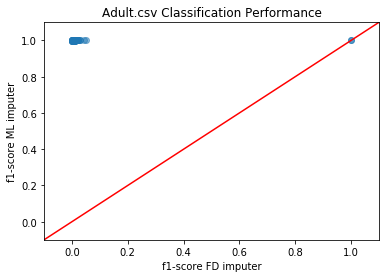

In [27]:
f1_fd = [y['f1'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'f1' in y.keys()]
f1_ml = [y['f1'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_fd, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score FD imputer',
      ylabel = 'f1-score ML imputer',
      xlim = [-0.1, 1.1],
      ylim  = [-0.1, 1.1])
fig.savefig('ml-fd-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')

## Plot MSE

In [28]:
mse_fd = [y['mse'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'mse' in y.keys()]
mse_ml = [y['mse'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'mse' in y.keys()]

In [32]:
rel_mse = []
for i, x in enumerate(mse_fd):
    if x != '':
        rel_mse.append(mse_fd[i]/mse_ml[i])
    else:
        rel_mse.append(np.nan)

Falls mse_fd / mse_ml > 1 ist, ist mse_ml kleiner als mse_fd um den Faktor, den man auf der y-Achse ablesen kann.
Generell ist diese Darstellung dubios, ich sollte die MSE lieber in einer Tabelle auffuehren.

[Text(0, 0.5, 'mse_fd / mse_ml'),
 (-0.1, 11),
 Text(0.5, 0, 'FD LHS combination'),
 Text(0.5, 1.0, 'Adult.csv Mean Squared Error of two imputers')]

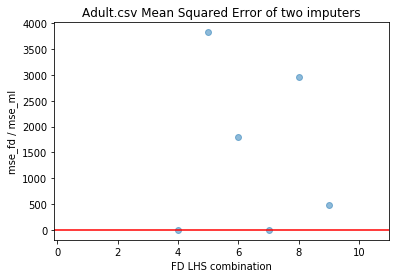

In [61]:
fig, ax = plt.subplots()
sc = plt.scatter(list(range(0, len(rel_mse))), 
                 rel_mse,
                 alpha=0.5)
plt.plot(np.linspace(-2, len(rel_mse)), [1]*50, c='red')
ax.set(title='Adult.csv Mean Squared Error of two imputers',
      xlabel = 'FD LHS combination',
      ylabel = 'mse_fd / mse_ml',
      xlim = [-0.1, 11])
#fig.savefig('ml-fd-regression.png', transparent=False,
           #dpi=320, bbox_inches='tight')

## 1. How to split the dataset

In [ ]:
df = pd.read_csv(DATA_PATH, sep=';', header=None)
fd_imputer.save_df_split(DATA_TITLE, df, SPLITS_PATH, METANOME_DATA_PATH, [0.8, 0.2])

## 2. How to use ML-imputer

Impute test-set

In [49]:
df_train.iloc[:, :-2].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,22855,23,Private,113309,Some-college,10,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40
1,18912,24,NaN,412156,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,40
2,17454,51,Private,139347,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,7688,0,40
3,14966,20,Private,223811,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40
4,12289,40,Self-emp-not-inc,48859,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32


In [86]:
df_imputed = fd_imputer.ml_imputer(df_train.iloc[:,[4,5]], 
                                   df_test.iloc[:,[4,5]],
                                   5)

2019-06-04 11:22:30,600 [INFO]  
========== start: fit model
2019-06-04 11:22:30,602 [WARNING]  Already bound, ignoring bind()
2019-06-04 11:22:32,287 [INFO]  Epoch[0] Batch [0-184]	Speed: 1763.98 samples/sec	cross-entropy=0.350771	5-accuracy=0.000000
2019-06-04 11:22:33,904 [INFO]  Epoch[0] Train-cross-entropy=0.176974
2019-06-04 11:22:33,907 [INFO]  Epoch[0] Train-5-accuracy=0.000000
2019-06-04 11:22:33,909 [INFO]  Epoch[0] Time cost=3.304
2019-06-04 11:22:33,913 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-04 11:22:34,267 [INFO]  Epoch[0] Validation-cross-entropy=0.000048
2019-06-04 11:22:34,269 [INFO]  Epoch[0] Validation-5-accuracy=0.000000
2019-06-04 11:22:35,904 [INFO]  Epoch[1] Batch [0-184]	Speed: 1821.23 samples/sec	cross-entropy=0.000005	5-accuracy=0.000000
2019-06-04 11:22:37,533 [INFO]  Epoch[1] Train-cross-entropy=0.000003
2019-06-04 11:22:37,931 [INFO]  Epoch[1] Train-5-accuracy=0.000000
2019-06-04 11:22:37,936 [INFO]  Epoch[1] Time cost=3.662
20

In [87]:
df_imputed.head()

,4,5,5_imputed
0,HS-grad,9,9.0
1,HS-grad,9,9.0
2,Assoc-voc,11,11.0
3,Some-college,10,10.0
4,Prof-school,15,15.0


In [ ]:
f1 = f1_score(df_imputed[impute_column], df_imputed[impute_column+'_imputed'].astype(int), average='weighted')
print(f1)

The ML model's mean relative error is roughly 0.2%

In [ ]:
average_rel_error = ((df_imputed[impute_column] - df_imputed[impute_column+'_imputed'])
 / df_imputed[impute_column]).mean()
print(average_rel_error)